In [15]:
import argparse
import os
import random

# deep learning
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
import torchvision.utils as vutils

# dataframes
import numpy as np
import pandas as pd

# plotting
import matplotlib.pyplot as plt
# from PIL import Image
# import matplotlib.animation as animation
# from IPython.display import HTML

# signal processing
from scipy import signal
import pywt

# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)
torch.use_deterministic_algorithms(True) # Needed for reproducible results

Random Seed:  999


In [16]:
device = torch.device("mps")

# number of channels the signal has
nc = 1

# Size of z latent vector (i.e. size of generator input)
nz = 300

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# number of signals per iteration
batch_size = 32

# Number of training epochs
num_epochs = 20

# Learning rate for optimizers
lr = 0.00002

# Beta1 hyperparameter for Adam optimizers
beta1 = 0.5

# type of gan
gans_type = "dcgans"

### Dataloader

Getting parameters such as data mean and sd for standardisation

In [17]:
gw_df = pd.read_csv('../data/gw-raw-data/richers_1764.csv')

# probability of augmenting data
aug_p = 0.5

# y-axis processing
# distance = 3.086e22
# gw_df = gw_df / distance

gw_mean = gw_df.mean().mean()
print('Dataset mean: ',  gw_mean)

gw_std = gw_df.std().std()
print('Dataset std: ',  gw_std)

gw_scaling_factor = 5
print('Dataset scaling factor (to match noise in generator): ',  gw_scaling_factor)

Dataset mean:  -0.04824243411562023
Dataset std:  12.791674600968692
Dataset scaling factor (to match noise in generator):  5


In [52]:


class GWDataset(Dataset):
    def __init__(self, csv_file):
        self.data = pd.read_csv(csv_file).astype('float32')
        self.data = self.data.values

    def calc_stats(self):
        self.mean = self.data.mean()
        self.std = self.data.std()

    def get_common(self):
        self.common_ylim_signal = (self.data[:,:].min(), self.data[:,:].max())
        return self.common_ylim_signal
    
    def standardize(self, signal):
        standardized_signal = (signal - dataset.mean) / dataset.std
        standardized_signal = standardized_signal / gw_scaling_factor
        return standardized_signal

    def shift_augmentation(self):
        augmented_signals = self.data.copy()
        
        for i in range(self.data.shape[1]):
            rand = np.random.random()
            if (rand < aug_p):
                signal = self.data[:, i]
                signal = signal.reshape(1, -1)

                shift = np.random.normal(0, 25, 1)
                augmented_signal = np.roll(signal, int(shift))
                augmented_signals = np.insert(augmented_signals, i, augmented_signal, axis=1)

        self.data = augmented_signals

    def __len__(self):
        return self.data.shape[1]

    def __getitem__(self, idx):
        signal = self.data[:, idx]
        signal = signal.reshape(1, -1)

        # process signal from strain * distance (10 kpc) -> just strain
        # distance = 3.086e22
        # signal = signal / distance

        # reshape signal to have first 512 - 407 values to be 0.
        desired_length = 512

        padding_left = (desired_length - len(signal[0])) // 2
        padding_right = desired_length - len(signal[0]) - padding_left

        signal_padded = np.pad(signal, ((0, 0), (padding_left, padding_right)), mode='edge')

        signal_standardized = self.standardize(signal_padded)

        return signal_standardized

dataset = GWDataset("../data/gw-raw-data/richers_1764.csv")
common_ylim_signal = dataset.get_common()
# dataset.shift_augmentation()
# dataset.shift_augmentation()
# dataset.shift_augmentation()
dataset.calc_stats()
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=0)

real_batch = next(iter(dataloader))

# Expecting: (32, 1, 512)
print(real_batch.shape)

common_ylim = (real_batch[:,:,:].min(), real_batch[:,:,:].max())

def plot_and_save_waveforms(real_batch, filename='waveforms.png'):
    fig, axes = plt.subplots(4, 4, figsize=(15, 12))
    axes = axes.flatten()
    
    # Plot each signal on a separate subplot
    for i, ax in enumerate(axes):
        x = np.arange(real_batch.size(dim=2))
        y = real_batch[i, :, :].flatten()
        ax.plot(x, y)

        ax.axvline(x=256, color='black', linestyle='--', alpha=0.5)
        ax.set_title(f'Signal {i+1}')
        ax.grid(True)
        ax.set_ylim(common_ylim)
    
    for i in range(512, 8*4):
        fig.delaxes(axes[i])
    
    plt.tight_layout()
    
    if filename:
        plt.savefig(filename)  # Save the plot to a PNG file
    
    plt.show()

# Example usage: Display and save the plot to 'waveforms.png'
plot_and_save_waveforms(real_batch, filename='../data/gw-dcgans-plots/real_data.png')

AttributeError: 'numpy.ndarray' object has no attribute 'values'

In [19]:
dataset.__len__()

5982

### Weight Initialisation (Random Noise)

In [20]:
# custom weights initialization called on ``netG`` and ``netD``
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

### Generator

In [21]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose1d(nz, ngf * 64, kernel_size=4, stride=1, padding=0, bias=False),
            nn.BatchNorm1d(ngf * 64),
            nn.LeakyReLU(True),

            nn.ConvTranspose1d(ngf * 64, ngf * 32, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm1d(ngf * 32),
            nn.LeakyReLU(True),

            nn.ConvTranspose1d(ngf * 32, ngf * 16, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm1d(ngf * 16),
            nn.LeakyReLU(True),

            nn.ConvTranspose1d(ngf * 16, ngf * 8, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm1d(ngf * 8),
            nn.LeakyReLU(True),

            nn.ConvTranspose1d(ngf * 8, ngf * 4, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm1d(ngf * 4),
            nn.LeakyReLU(True),

            nn.ConvTranspose1d(ngf * 4, ngf * 2, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm1d(ngf * 2),
            nn.LeakyReLU(True),

            nn.ConvTranspose1d(ngf * 2, ngf, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm1d(ngf),
            nn.LeakyReLU(True),

            nn.ConvTranspose1d(ngf, nc, kernel_size=4, stride=2, padding=1, bias=False),
        )

    def forward(self, x):
        # print(x.shape)
        x = self.main(x)
        return x

In [22]:
# # Create the generator
netG = Generator().to(device)
netG.apply(weights_init)

print(netG)

model = Generator()
summary(model, input_size=(nz, 1))

Generator(
  (main): Sequential(
    (0): ConvTranspose1d(300, 4096, kernel_size=(4,), stride=(1,), bias=False)
    (1): BatchNorm1d(4096, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=True)
    (3): ConvTranspose1d(4096, 2048, kernel_size=(4,), stride=(2,), padding=(1,), bias=False)
    (4): BatchNorm1d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=True)
    (6): ConvTranspose1d(2048, 1024, kernel_size=(4,), stride=(2,), padding=(1,), bias=False)
    (7): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=True)
    (9): ConvTranspose1d(1024, 512, kernel_size=(4,), stride=(2,), padding=(1,), bias=False)
    (10): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): LeakyReLU(negative_slope=True)
    (12): ConvTranspose1d(512, 256, kernel_size=(4,), stride=(2,), padding=(1,), b

### Discriminator

In [23]:
if (gans_type == "dcgans"):
    class Discriminator(nn.Module):
        def __init__(self):
            super(Discriminator, self).__init__()
            self.main = nn.Sequential(
                nn.Conv1d(nc, ndf, kernel_size=4, stride=2, padding=1, bias=False),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Dropout(0.25),

                nn.Conv1d(ndf, ndf * 2, kernel_size=4, stride=2, padding=1, bias=False),
                nn.BatchNorm1d(ndf * 2),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Dropout(0.25),

                nn.Conv1d(ndf * 2, ndf * 4, kernel_size=4,
                        stride=2, padding=1, bias=False),
                nn.BatchNorm1d(ndf * 4),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Dropout(0.25),

                nn.Conv1d(ndf * 4, ndf * 8, kernel_size=4,
                        stride=2, padding=1, bias=False),
                nn.BatchNorm1d(ndf * 8),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Dropout(0.25),

                nn.Conv1d(ndf * 8, ndf * 16, kernel_size=4,
                        stride=2, padding=1, bias=False),
                nn.BatchNorm1d(ndf * 16),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Dropout(0.25),

                nn.Conv1d(ndf * 16, ndf * 32, kernel_size=4,
                        stride=2, padding=1, bias=False),
                nn.BatchNorm1d(ndf * 32),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Dropout(0.25),

                nn.Conv1d(ndf * 32, ndf * 64, kernel_size=4,
                        stride=2, padding=1, bias=False),
                nn.BatchNorm1d(ndf * 64),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Dropout(0.25),
                
                nn.Conv1d(ndf * 64, nc, kernel_size=4,
                        stride=2, padding=0, bias=False),
            )

            # fully conencted layer to output probability
            self.fc = nn.Sequential(
                nn.Dropout(0.25),
                nn.Sigmoid()
            )

        def forward(self, x, y=None):
            # print(x.shape)
            x = self.main(x)
            # print(x.shape)
            x = x.view(x.shape[0], -1)  # Flatten the tensor
            x = self.fc(x)
            # print(x)
            return x

elif (gans_type == "wgans"):
    class Critic(nn.Module):
        def __init__(self):
            super(Critic, self).__init__()
            self.main = nn.Sequential(
                # xl kernel, stride and padding on this one (first layer group)
                nn.Conv1d(nc, ndf, kernel_size=8, stride=4, padding=2, bias=False),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Dropout(0.25),

                nn.Conv1d(ndf, ndf * 2, kernel_size=4, stride=2, padding=1, bias=False),
                nn.BatchNorm1d(ndf * 2),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Dropout(0.25),

                nn.Conv1d(ndf * 2, ndf * 4, kernel_size=4,
                        stride=2, padding=1, bias=False),
                nn.BatchNorm1d(ndf * 4),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Dropout(0.25),

                nn.Conv1d(ndf * 4, ndf * 8, kernel_size=4,
                        stride=2, padding=1, bias=False),
                nn.BatchNorm1d(ndf * 8),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Dropout(0.25),

                nn.Conv1d(ndf * 8, ndf * 16, kernel_size=4,
                        stride=2, padding=1, bias=False),
                nn.BatchNorm1d(ndf * 16),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Dropout(0.25),

                nn.Conv1d(ndf * 16, ndf * 32, kernel_size=4,
                        stride=2, padding=1, bias=False),
                nn.BatchNorm1d(ndf * 32),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Dropout(0.25),

                # xl kernel, stride and padding on this one (last layer group)
                nn.Conv1d(ndf * 32, nc, kernel_size=8,
                        stride=4, padding=2, bias=False),
            )

        def forward(self, x, y=None):
            # print(x.shape)
            x = self.main(x)
            # print(x.shape)
            x = x.view(x.shape[0], -1)  # Flatten the tensor
            # x = self.fc(x)
            # print(x)
            return x

In [24]:
if (gans_type == "dcgans"):
    netD = Discriminator().to(device)
    netD.apply(weights_init)

    print(netD)

    model = Discriminator()
    summary(model, input_size=(1, 512))

elif (gans_type == "wgans"):
    netC = Critic().to(device)
    netC.apply(weights_init)

    print(netC)

    model = Critic()
    summary(model, input_size=(1, 512))

Discriminator(
  (main): Sequential(
    (0): Conv1d(1, 64, kernel_size=(4,), stride=(2,), padding=(1,), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout(p=0.25, inplace=False)
    (3): Conv1d(64, 128, kernel_size=(4,), stride=(2,), padding=(1,), bias=False)
    (4): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): Dropout(p=0.25, inplace=False)
    (7): Conv1d(128, 256, kernel_size=(4,), stride=(2,), padding=(1,), bias=False)
    (8): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): LeakyReLU(negative_slope=0.2, inplace=True)
    (10): Dropout(p=0.25, inplace=False)
    (11): Conv1d(256, 512, kernel_size=(4,), stride=(2,), padding=(1,), bias=False)
    (12): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): LeakyReLU(negative_slope=0.2, inplace=True)
    (14): Dropout(p=0.25, inp

### Loss functions and Optimisers

In [25]:
# Initialize the ``BCELoss`` function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
# the progression of the generator
fixed_noise = torch.randn(batch_size, nz, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.0
fake_label = 0.0

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

### Training

Starting Training Loop...
[0/20][0/187]	Loss_D: 2.0094	Loss_G: 0.7717	D(x): 0.3538	D(G(z)): 0.3985 / 0.3878
[0/20][50/187]	Loss_D: 0.9392	Loss_G: 2.5387	D(x): 0.1739	D(G(z)): 0.7053 / 0.7090
[0/20][100/187]	Loss_D: 0.8365	Loss_G: 2.1706	D(x): 0.1413	D(G(z)): 0.7820 / 0.7137
[0/20][150/187]	Loss_D: 0.5662	Loss_G: 2.2968	D(x): 0.1433	D(G(z)): 0.6932 / 0.7472


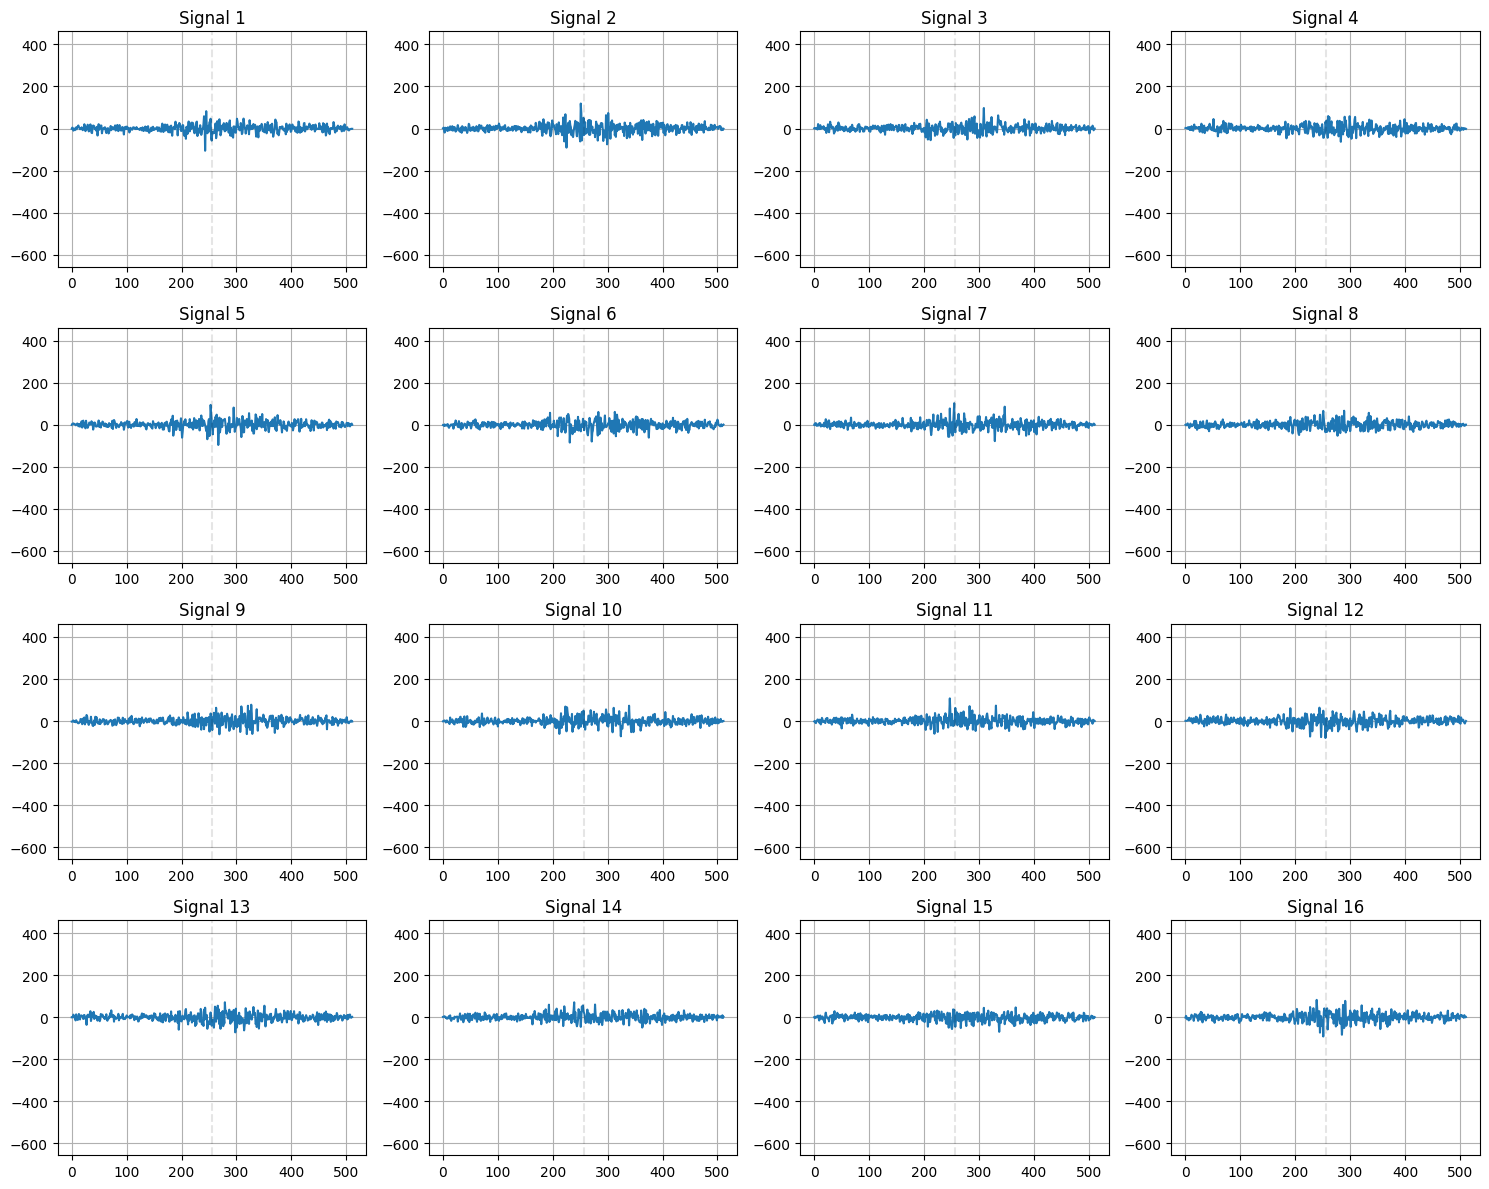

[1/20][0/187]	Loss_D: 0.7934	Loss_G: 3.6540	D(x): 0.1100	D(G(z)): 0.7333 / 0.8264
[1/20][50/187]	Loss_D: 0.8460	Loss_G: 2.2779	D(x): 0.1630	D(G(z)): 0.7466 / 0.7231
[1/20][100/187]	Loss_D: 0.9883	Loss_G: 2.6274	D(x): 0.1699	D(G(z)): 0.7526 / 0.8266
[1/20][150/187]	Loss_D: 0.9015	Loss_G: 2.7905	D(x): 0.2352	D(G(z)): 0.7960 / 0.7733


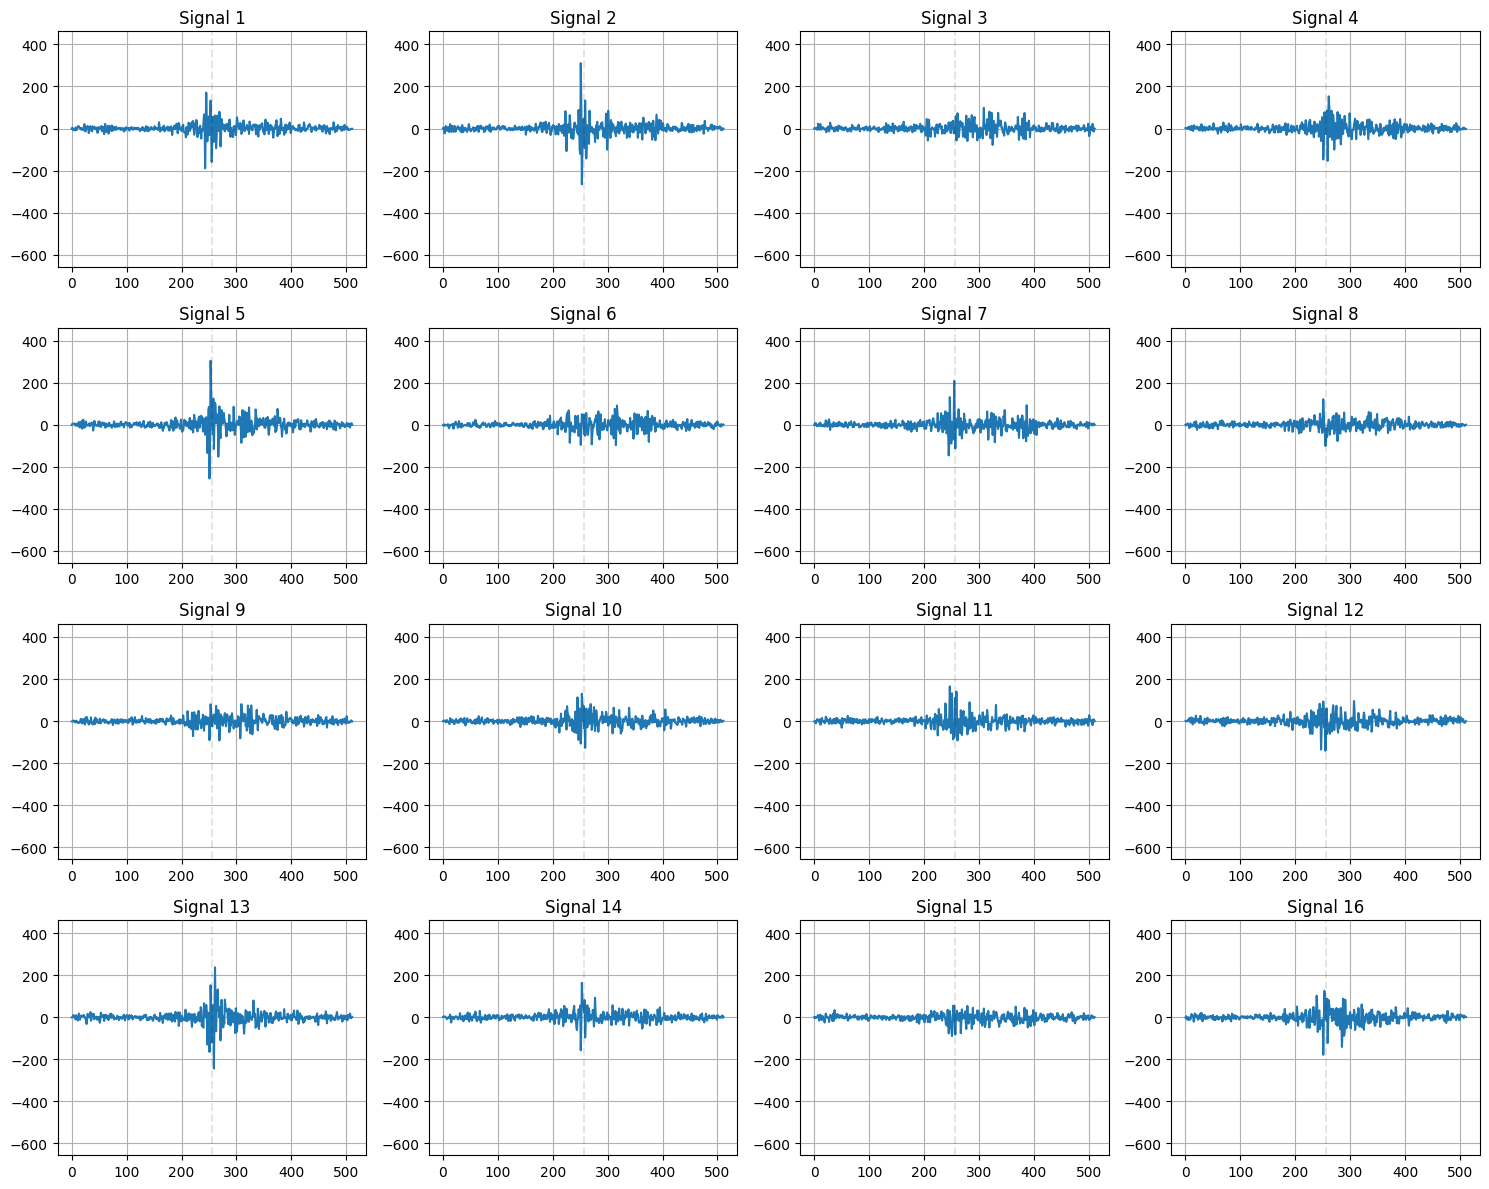

[2/20][0/187]	Loss_D: 0.6428	Loss_G: 2.1386	D(x): 0.1140	D(G(z)): 0.7846 / 0.7397
[2/20][50/187]	Loss_D: 0.7789	Loss_G: 2.2529	D(x): 0.1989	D(G(z)): 0.7881 / 0.7291
[2/20][100/187]	Loss_D: 0.9771	Loss_G: 2.8281	D(x): 0.2303	D(G(z)): 0.7802 / 0.8116
[2/20][150/187]	Loss_D: 0.8733	Loss_G: 3.2636	D(x): 0.1639	D(G(z)): 0.7467 / 0.8073


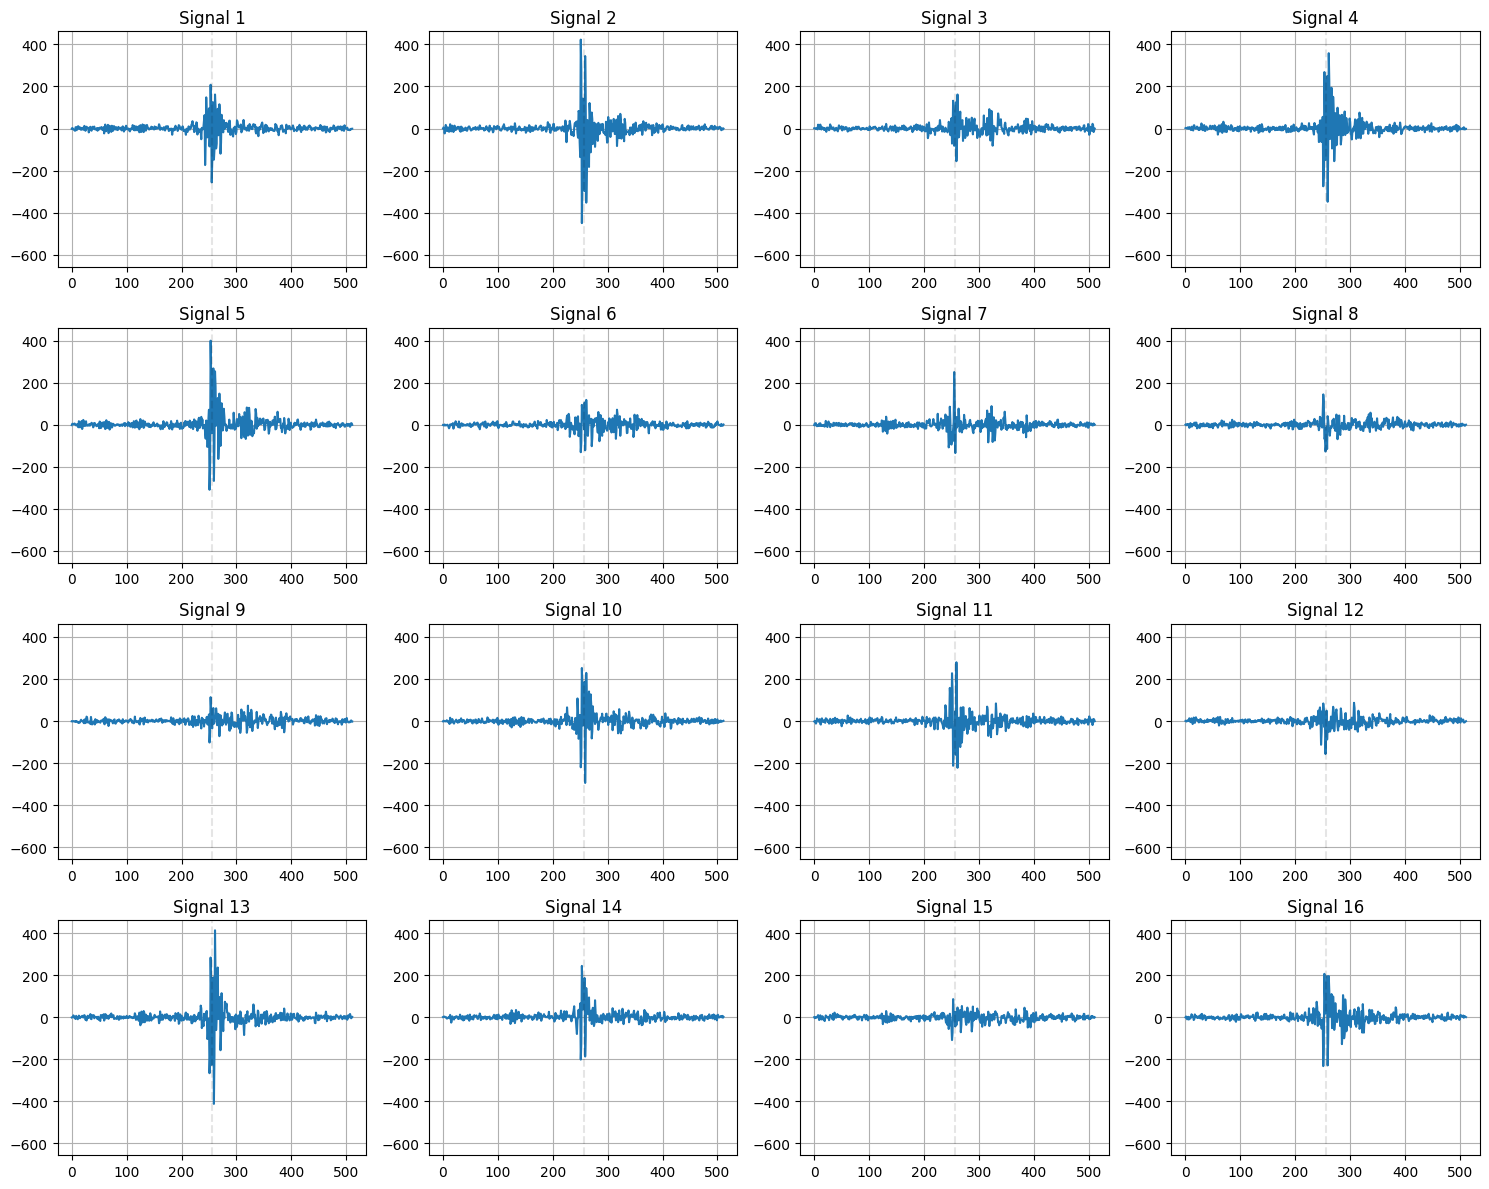

[3/20][0/187]	Loss_D: 0.8410	Loss_G: 2.9013	D(x): 0.1994	D(G(z)): 0.7799 / 0.8348
[3/20][50/187]	Loss_D: 0.8406	Loss_G: 2.7863	D(x): 0.1300	D(G(z)): 0.8804 / 0.7677
[3/20][100/187]	Loss_D: 0.8795	Loss_G: 2.5311	D(x): 0.1592	D(G(z)): 0.7551 / 0.7832
[3/20][150/187]	Loss_D: 0.9765	Loss_G: 1.9912	D(x): 0.0672	D(G(z)): 0.9103 / 0.6738


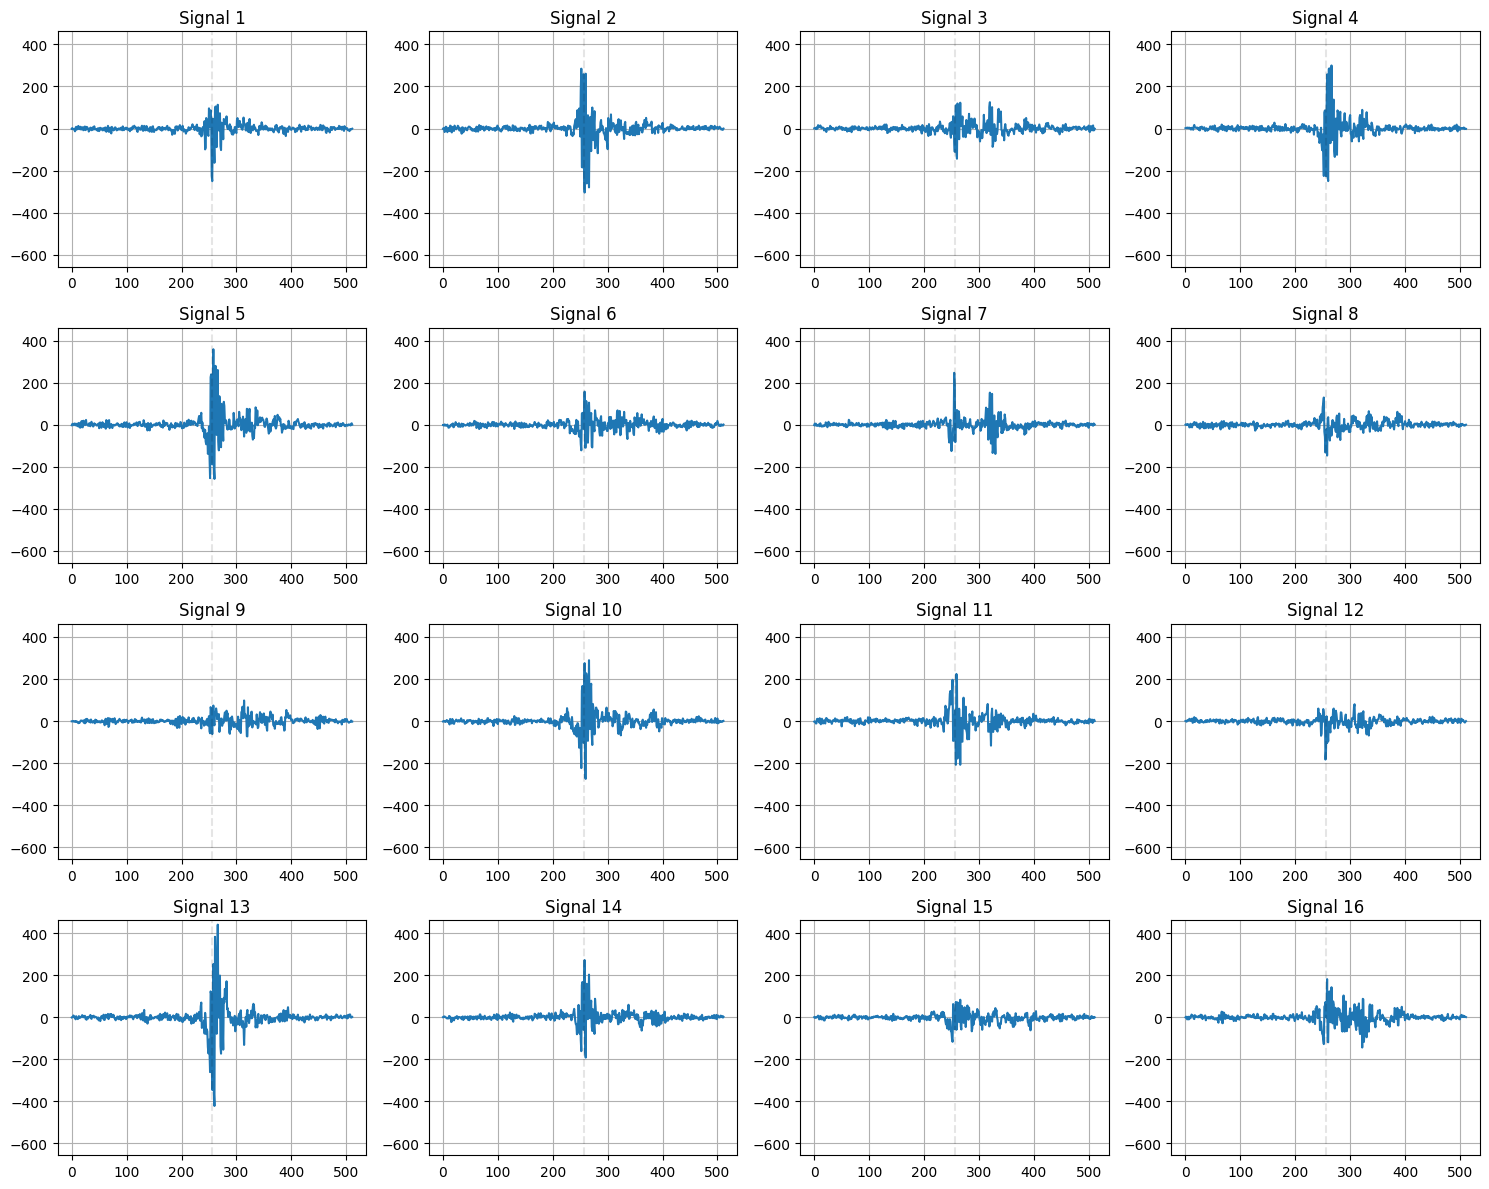

[4/20][0/187]	Loss_D: 0.8682	Loss_G: 3.1216	D(x): 0.1439	D(G(z)): 0.7485 / 0.7652
[4/20][50/187]	Loss_D: 1.0281	Loss_G: 2.9006	D(x): 0.1406	D(G(z)): 0.7365 / 0.8605
[4/20][100/187]	Loss_D: 0.8547	Loss_G: 4.1722	D(x): 0.1463	D(G(z)): 0.6982 / 0.8586
[4/20][150/187]	Loss_D: 0.9866	Loss_G: 2.8083	D(x): 0.1917	D(G(z)): 0.8029 / 0.7993


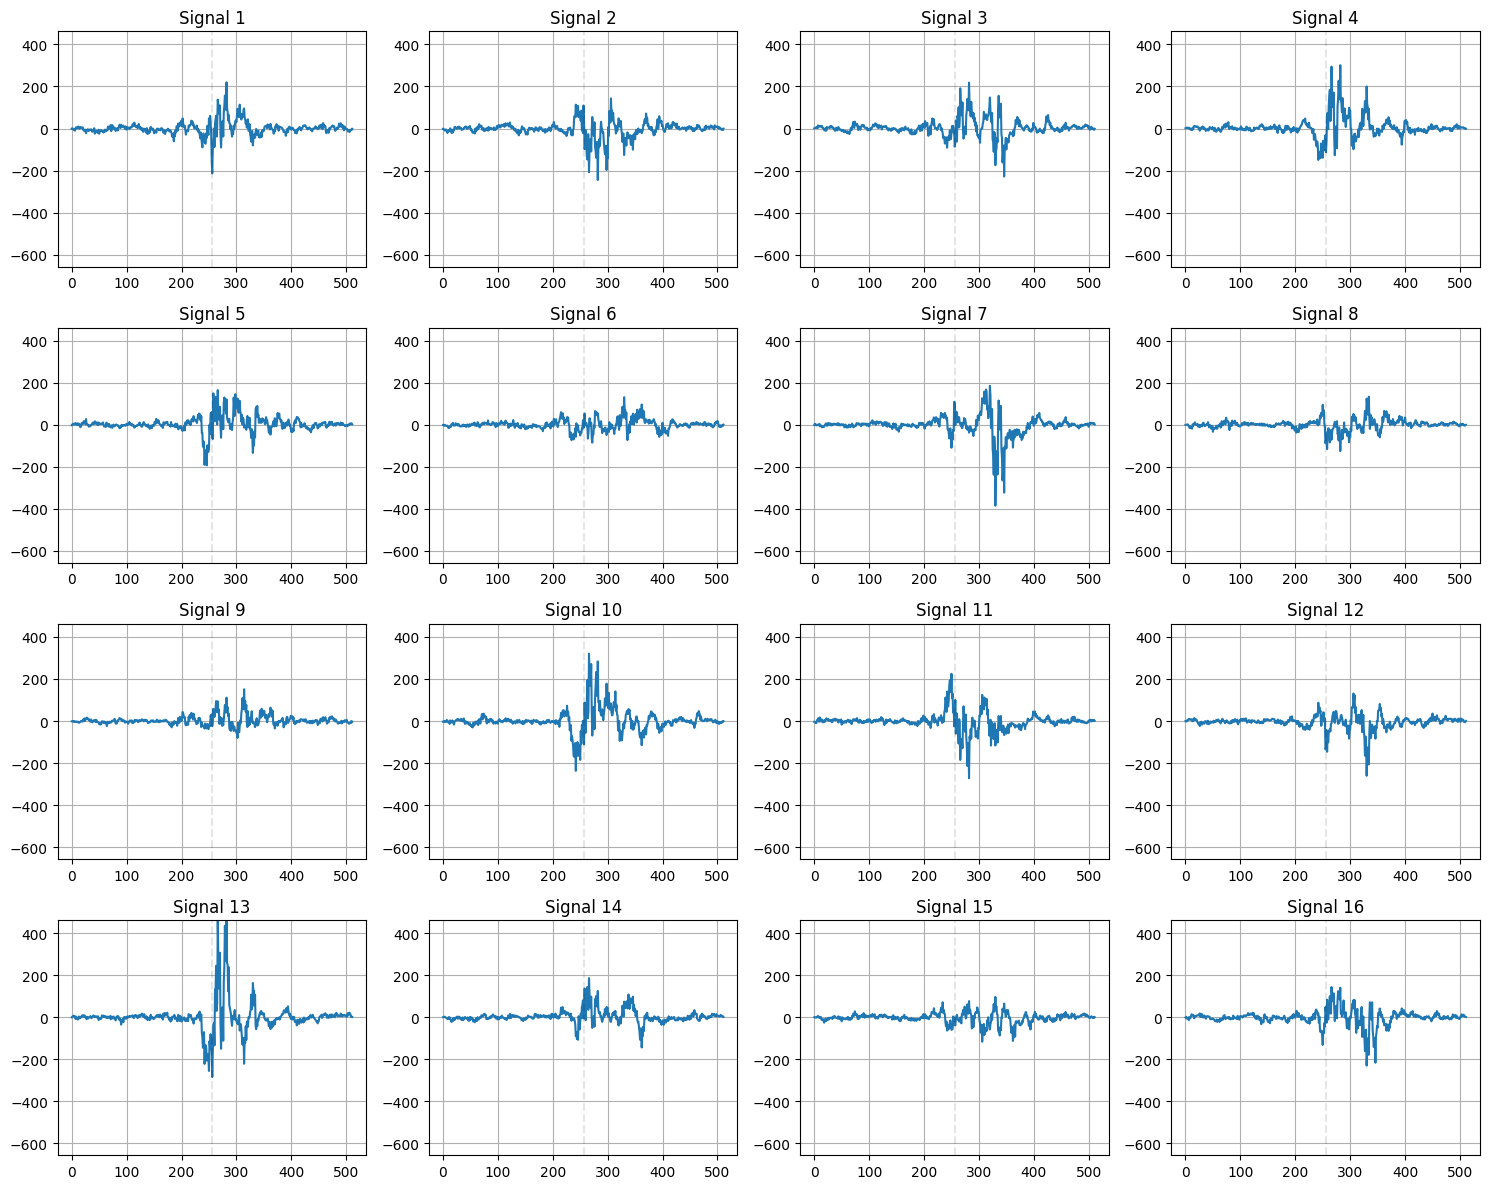

[5/20][0/187]	Loss_D: 0.8284	Loss_G: 2.6686	D(x): 0.0754	D(G(z)): 0.7479 / 0.7204
[5/20][50/187]	Loss_D: 1.0983	Loss_G: 1.7987	D(x): 0.1947	D(G(z)): 0.7727 / 0.6696
[5/20][100/187]	Loss_D: 1.2363	Loss_G: 2.4698	D(x): 0.1461	D(G(z)): 0.5325 / 0.7559
[5/20][150/187]	Loss_D: 0.9942	Loss_G: 1.2899	D(x): 0.1980	D(G(z)): 0.7689 / 0.5862


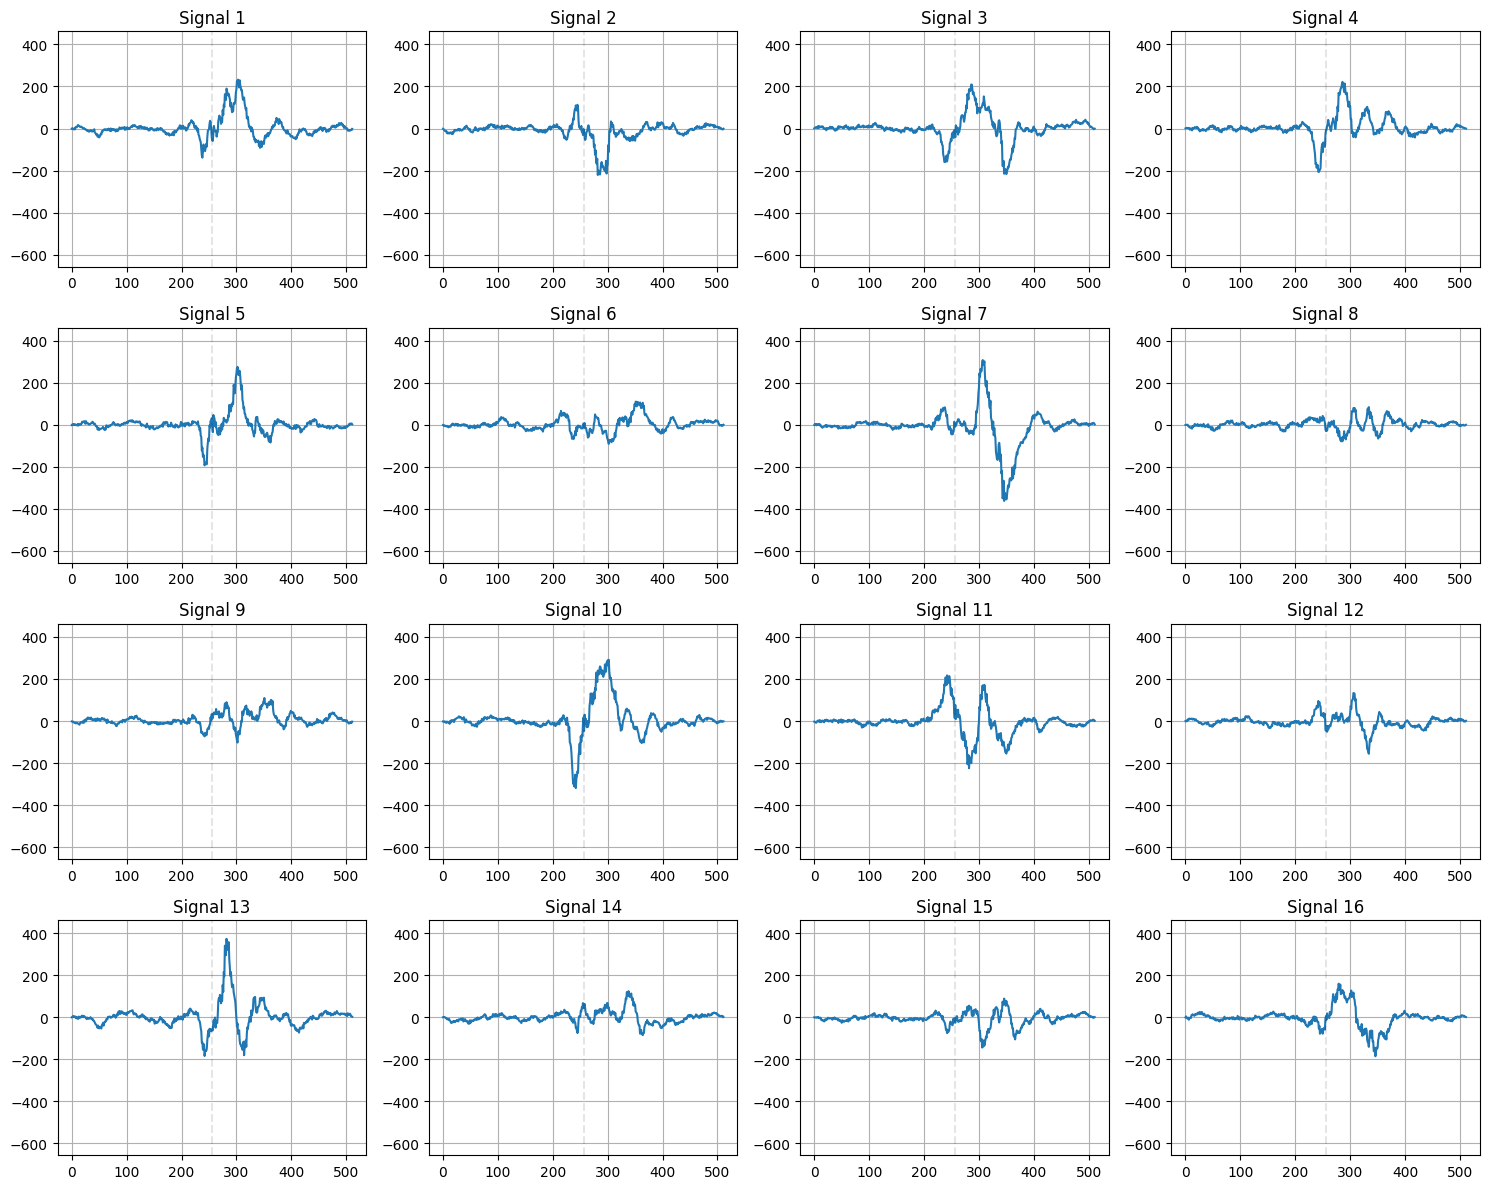

[6/20][0/187]	Loss_D: 0.9732	Loss_G: 3.5192	D(x): 0.1238	D(G(z)): 0.7487 / 0.8049
[6/20][50/187]	Loss_D: 0.8248	Loss_G: 3.5713	D(x): 0.1755	D(G(z)): 0.7965 / 0.8442
[6/20][100/187]	Loss_D: 0.9970	Loss_G: 2.8968	D(x): 0.1268	D(G(z)): 0.7682 / 0.7899
[6/20][150/187]	Loss_D: 0.8395	Loss_G: 2.5554	D(x): 0.1292	D(G(z)): 0.8861 / 0.7892


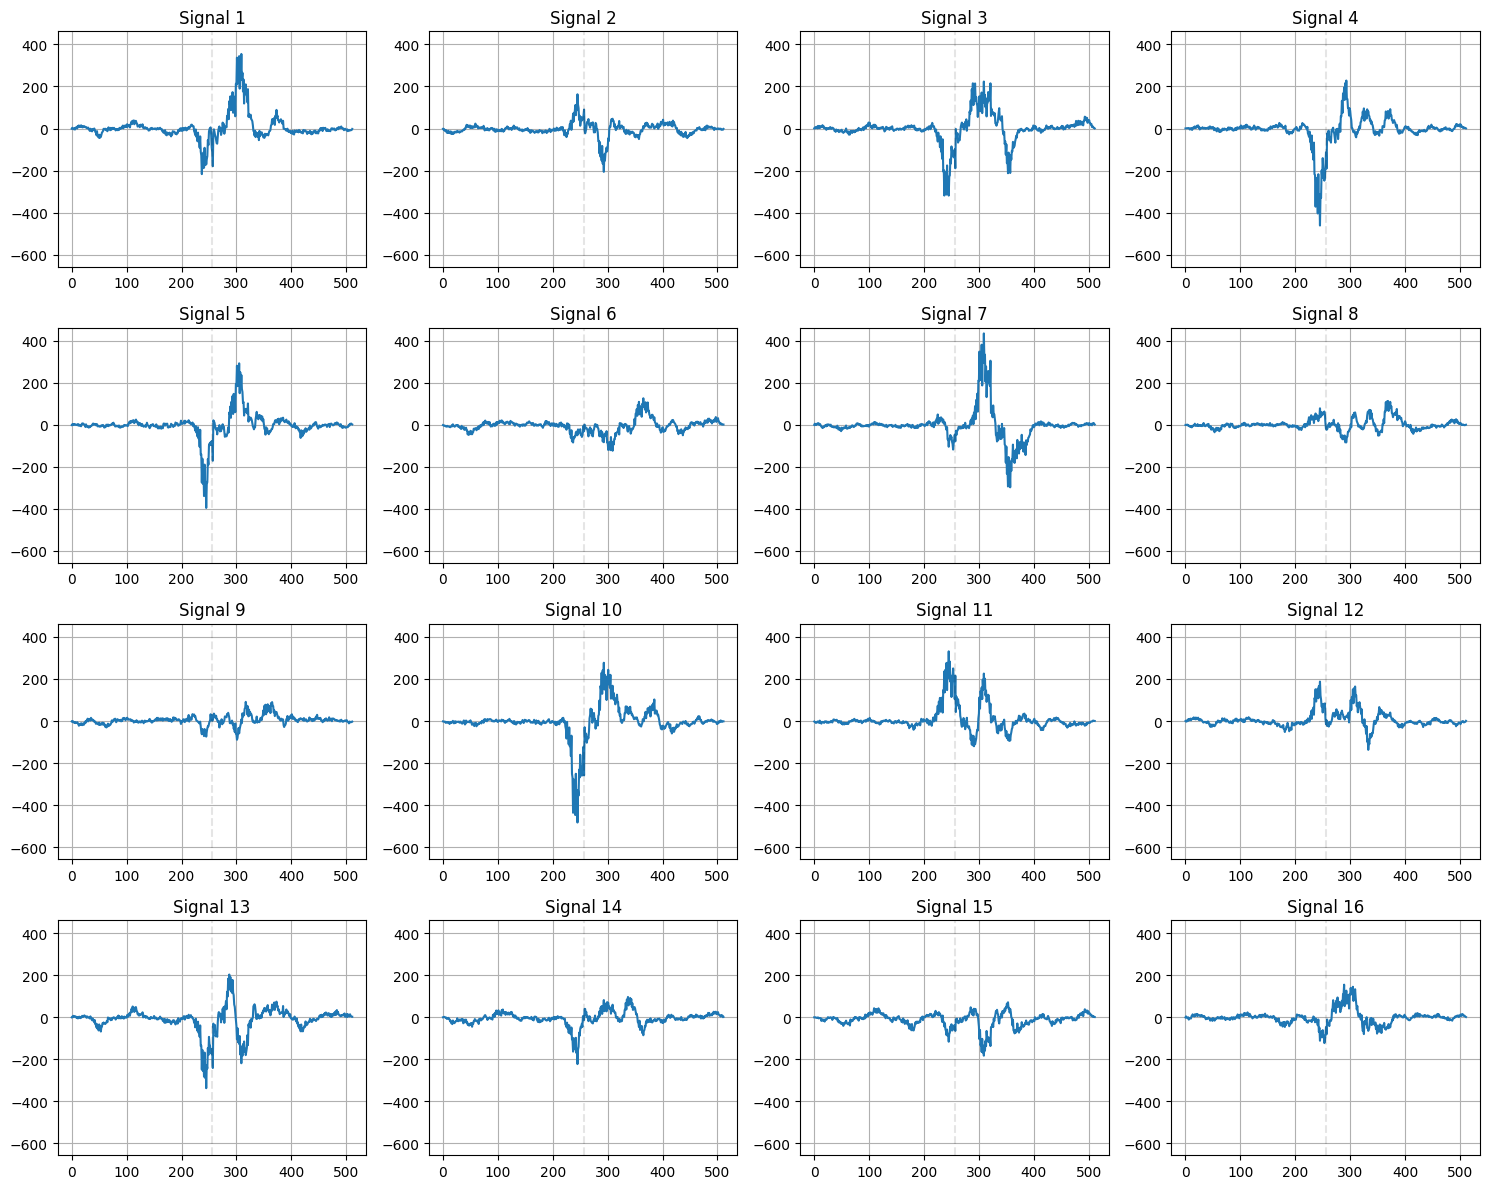

[7/20][0/187]	Loss_D: 0.9931	Loss_G: 1.7200	D(x): 0.1254	D(G(z)): 0.7137 / 0.7347
[7/20][50/187]	Loss_D: 0.9219	Loss_G: 3.3689	D(x): 0.1458	D(G(z)): 0.7386 / 0.8534
[7/20][100/187]	Loss_D: 0.7082	Loss_G: 2.0060	D(x): 0.1476	D(G(z)): 0.6756 / 0.7213
[7/20][150/187]	Loss_D: 0.8861	Loss_G: 4.3901	D(x): 0.1711	D(G(z)): 0.8304 / 0.8246


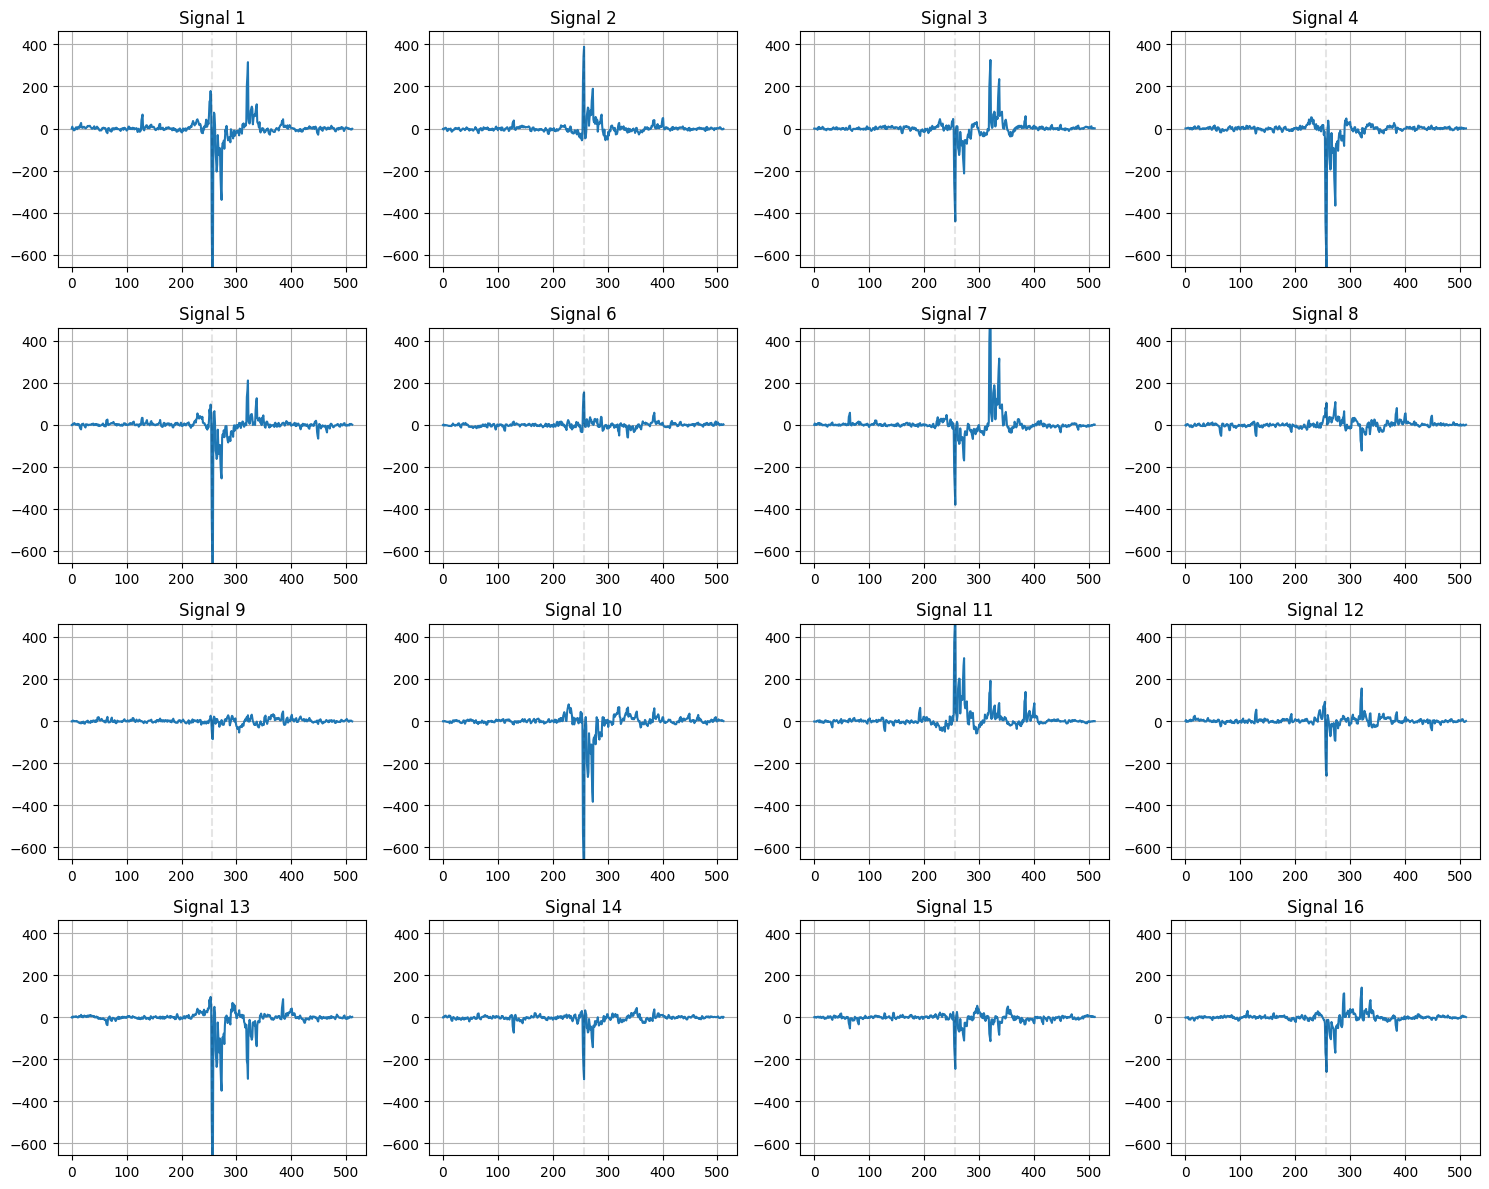

[8/20][0/187]	Loss_D: 0.8500	Loss_G: 3.0127	D(x): 0.1499	D(G(z)): 0.7672 / 0.8227
[8/20][50/187]	Loss_D: 1.3285	Loss_G: 2.2741	D(x): 0.1458	D(G(z)): 0.7227 / 0.7263
[8/20][100/187]	Loss_D: 0.9585	Loss_G: 2.4987	D(x): 0.1067	D(G(z)): 0.7461 / 0.7409
[8/20][150/187]	Loss_D: 0.7849	Loss_G: 2.0387	D(x): 0.1845	D(G(z)): 0.7922 / 0.7082


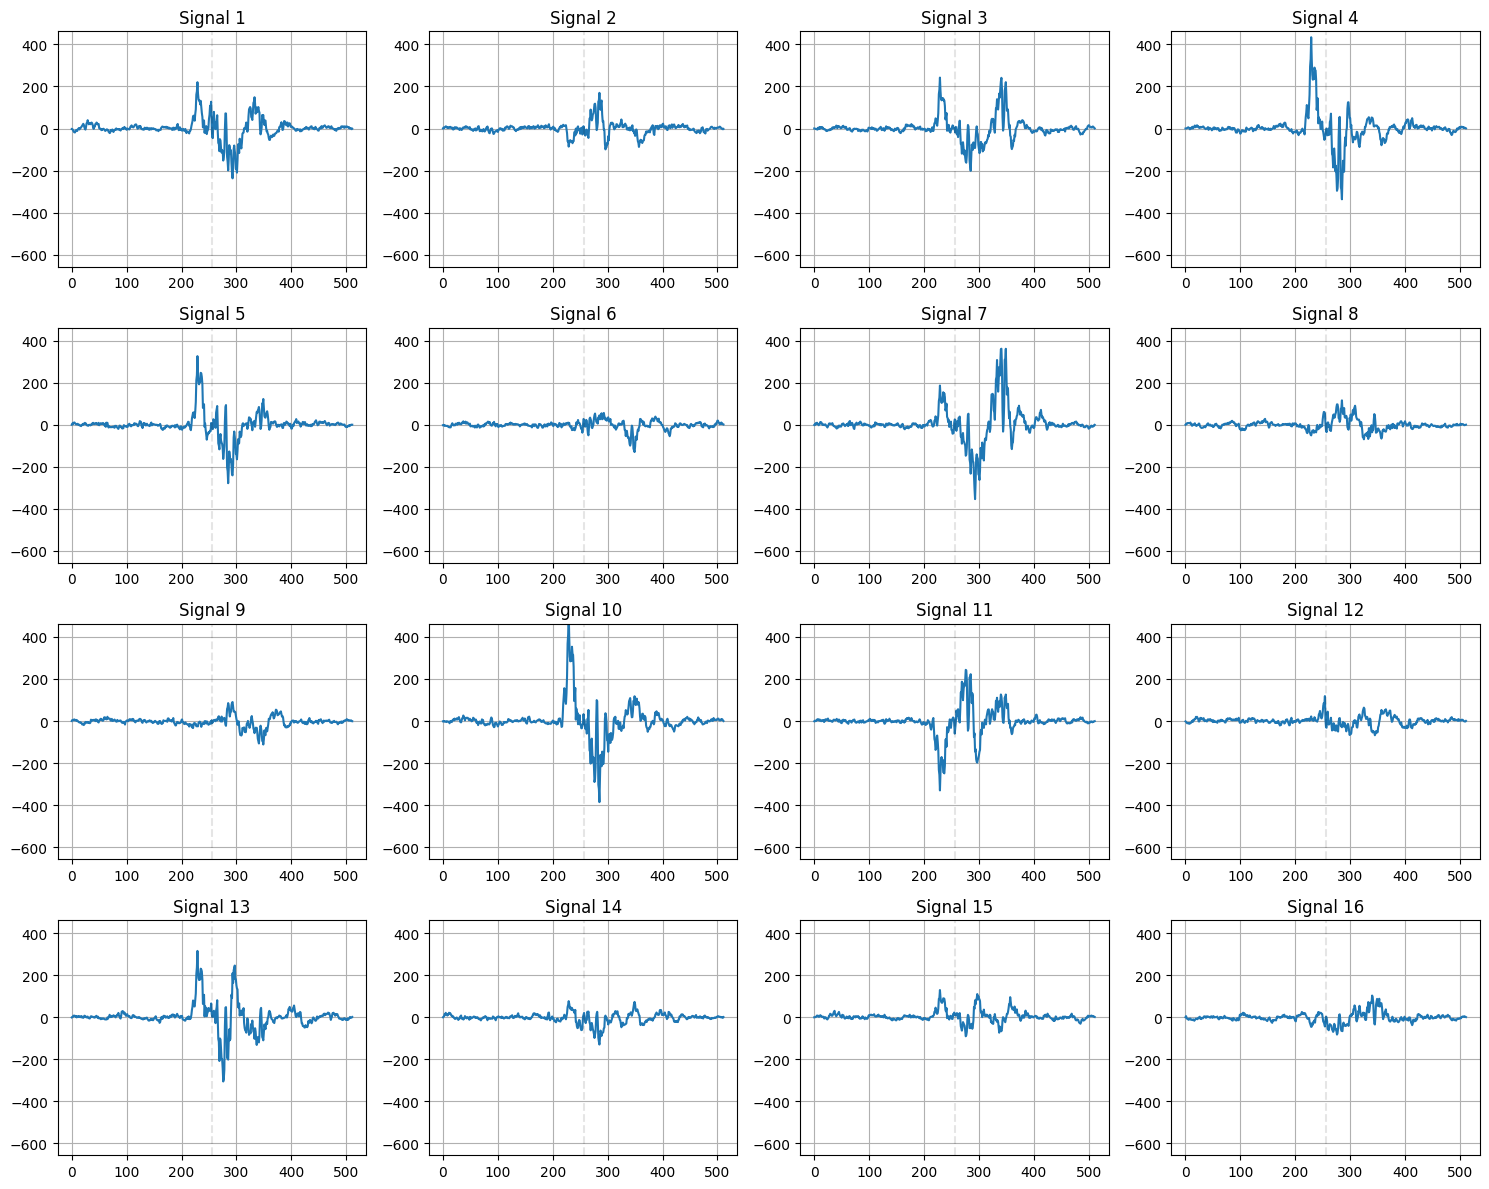

[9/20][0/187]	Loss_D: 0.9708	Loss_G: 2.7664	D(x): 0.1718	D(G(z)): 0.7443 / 0.7910
[9/20][50/187]	Loss_D: 0.7312	Loss_G: 2.1973	D(x): 0.0872	D(G(z)): 0.7046 / 0.7735
[9/20][100/187]	Loss_D: 0.7692	Loss_G: 2.9576	D(x): 0.1322	D(G(z)): 0.8046 / 0.7971
[9/20][150/187]	Loss_D: 0.7960	Loss_G: 2.8255	D(x): 0.1756	D(G(z)): 0.6451 / 0.8100


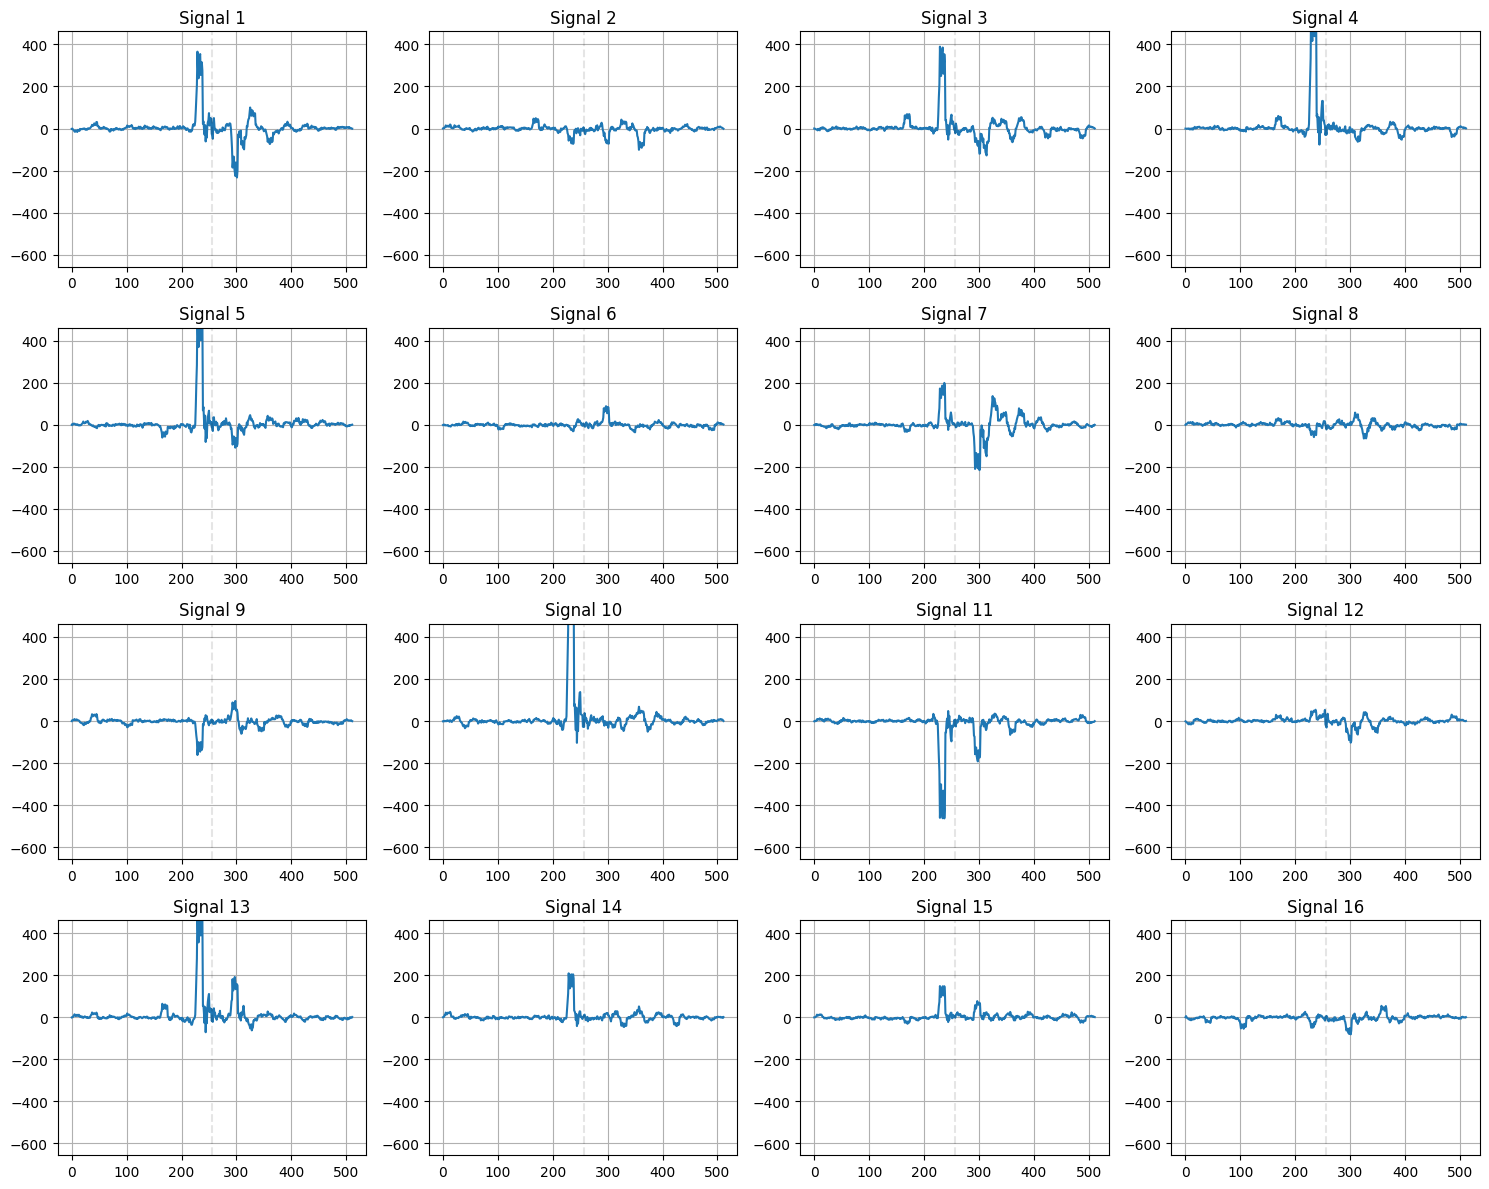

[10/20][0/187]	Loss_D: 1.2415	Loss_G: 4.7234	D(x): 0.0943	D(G(z)): 0.7535 / 0.9167
[10/20][50/187]	Loss_D: 0.6155	Loss_G: 2.6538	D(x): 0.0940	D(G(z)): 0.7465 / 0.7915
[10/20][100/187]	Loss_D: 0.9421	Loss_G: 1.9376	D(x): 0.1630	D(G(z)): 0.8154 / 0.7367
[10/20][150/187]	Loss_D: 0.8165	Loss_G: 2.3920	D(x): 0.0856	D(G(z)): 0.8053 / 0.7593


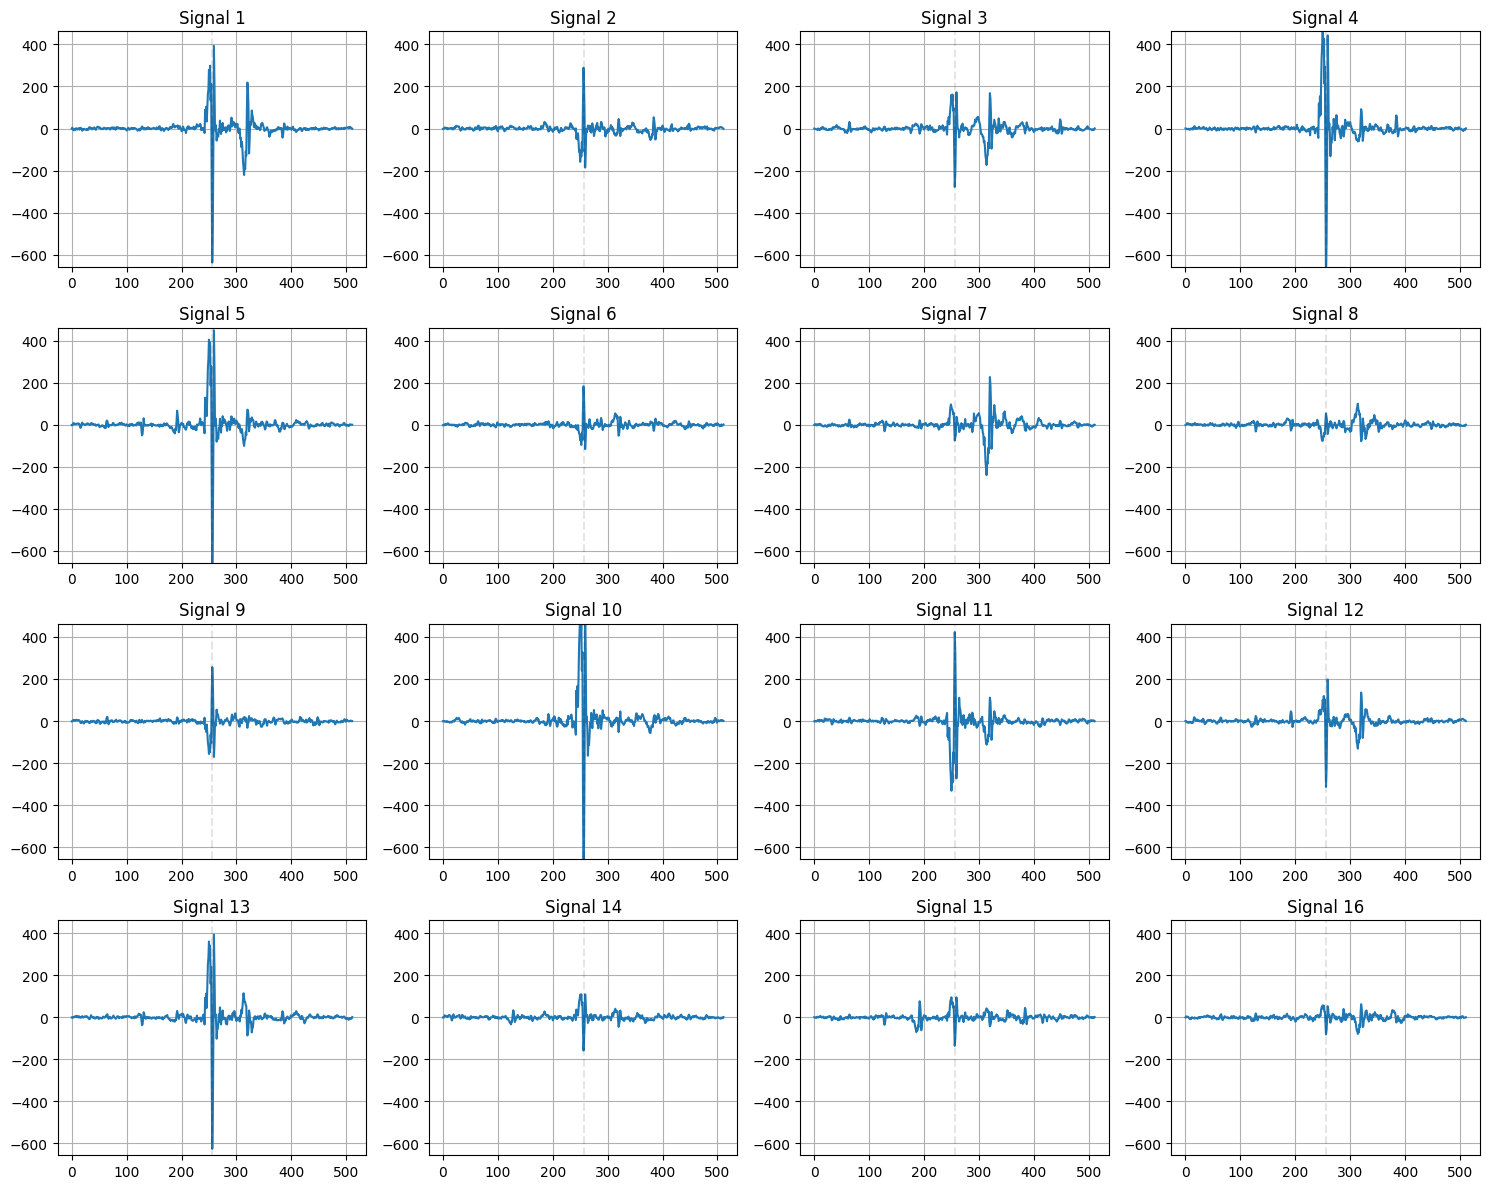

[11/20][0/187]	Loss_D: 0.8956	Loss_G: 3.0664	D(x): 0.1581	D(G(z)): 0.8256 / 0.8074
[11/20][50/187]	Loss_D: 1.0716	Loss_G: 2.6653	D(x): 0.1128	D(G(z)): 0.5464 / 0.8094
[11/20][100/187]	Loss_D: 1.0851	Loss_G: 1.3780	D(x): 0.2276	D(G(z)): 0.7472 / 0.6706
[11/20][150/187]	Loss_D: 0.7126	Loss_G: 2.4592	D(x): 0.1134	D(G(z)): 0.7576 / 0.7589


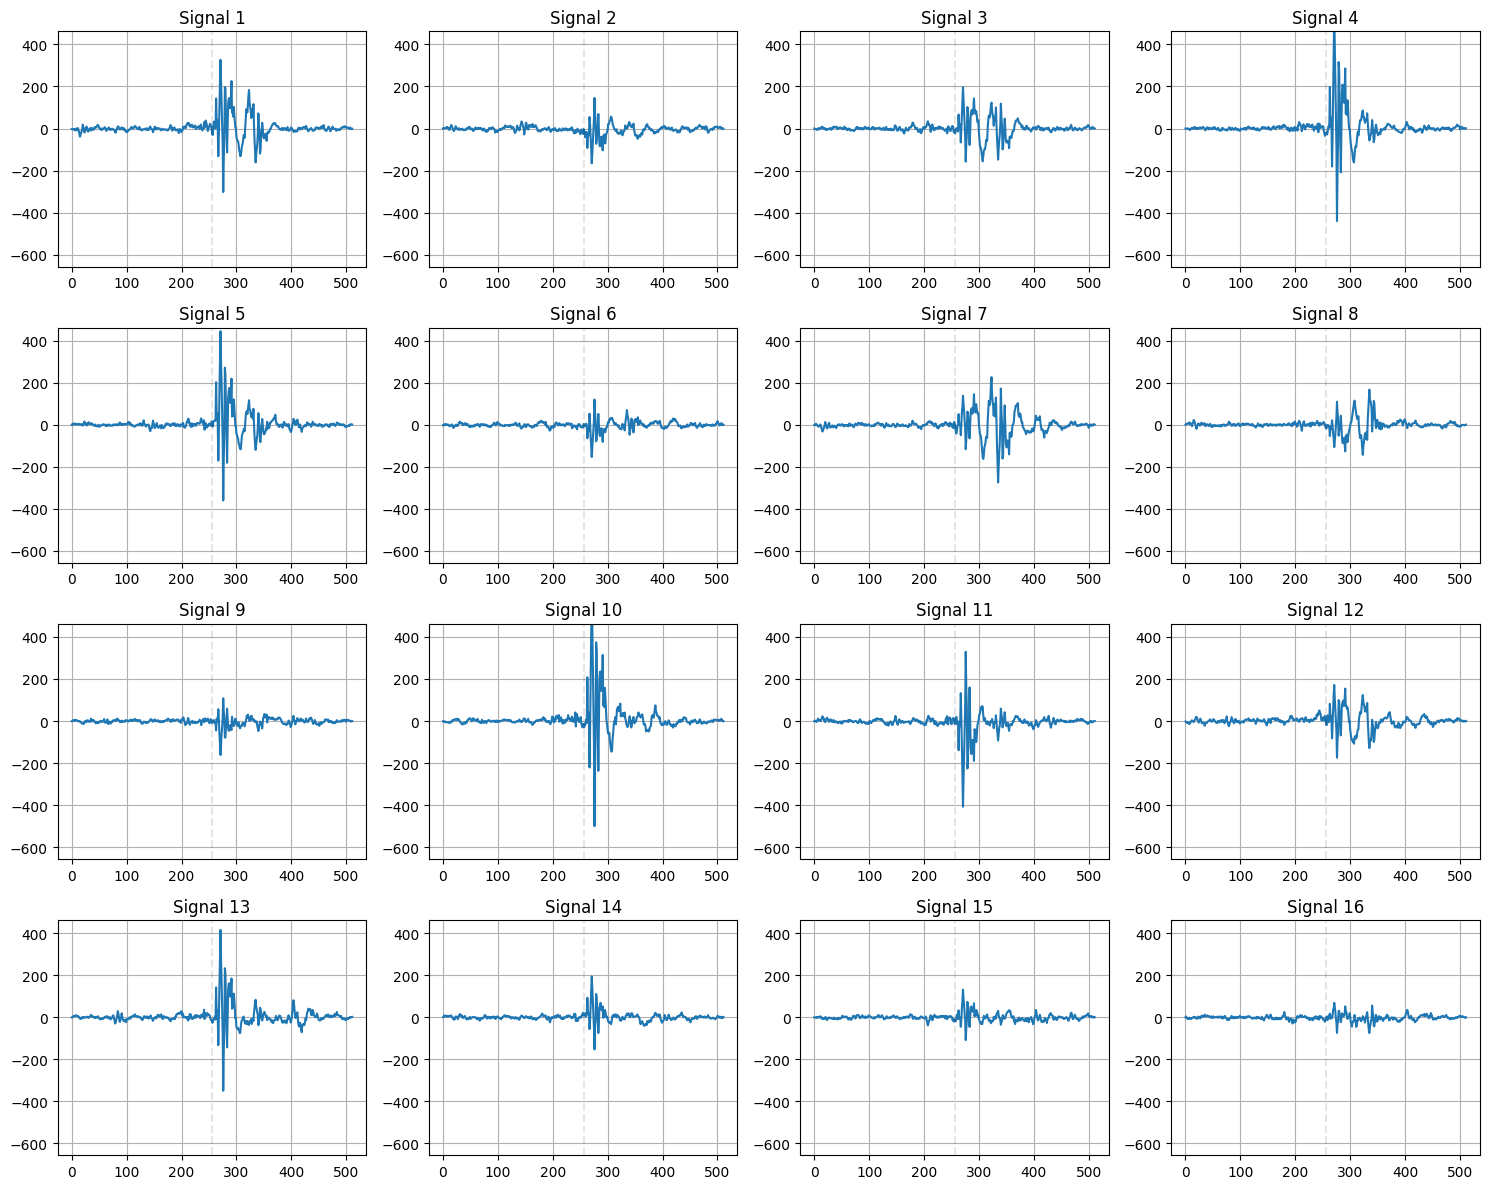

[12/20][0/187]	Loss_D: 1.0758	Loss_G: 2.5575	D(x): 0.0837	D(G(z)): 0.7546 / 0.7489
[12/20][50/187]	Loss_D: 0.7305	Loss_G: 2.5125	D(x): 0.1648	D(G(z)): 0.7345 / 0.8252
[12/20][100/187]	Loss_D: 0.2273	Loss_G: 1.9140	D(x): 0.0823	D(G(z)): 0.7846 / 0.7314
[12/20][150/187]	Loss_D: 0.9424	Loss_G: 1.7428	D(x): 0.1331	D(G(z)): 0.6880 / 0.7111


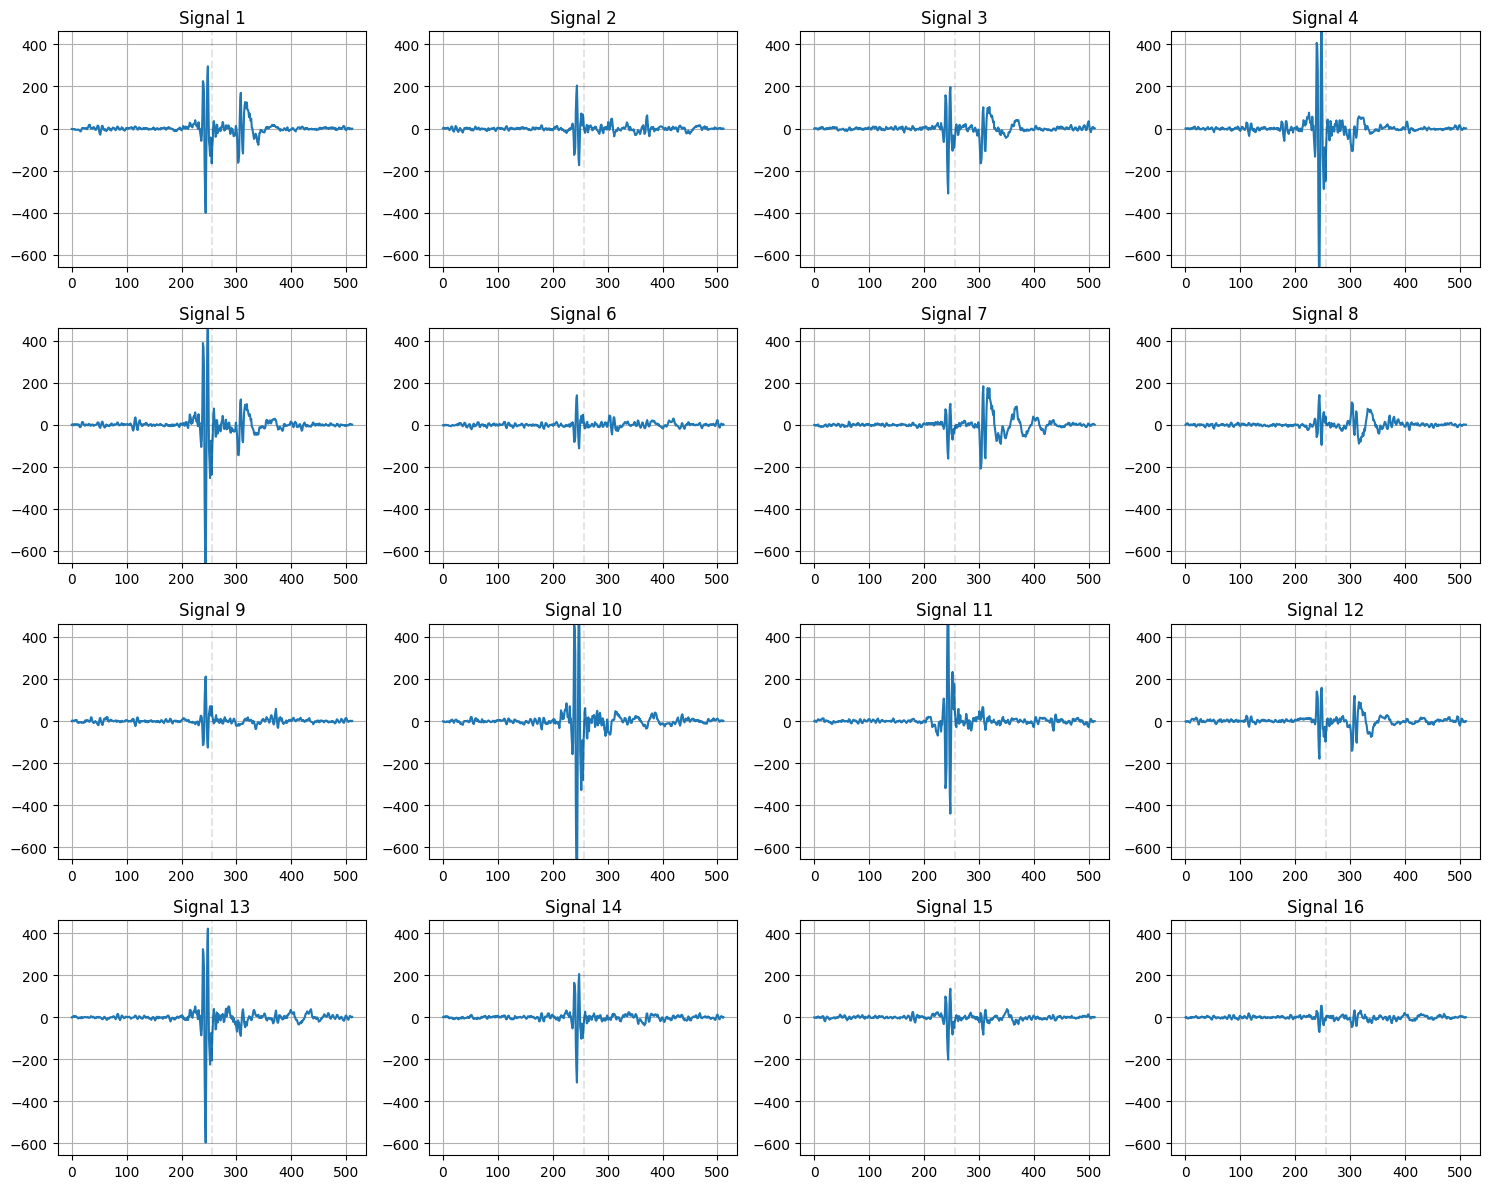

[13/20][0/187]	Loss_D: 0.8647	Loss_G: 1.7337	D(x): 0.1993	D(G(z)): 0.8320 / 0.7220
[13/20][50/187]	Loss_D: 0.9891	Loss_G: 3.9139	D(x): 0.2284	D(G(z)): 0.6960 / 0.8229
[13/20][100/187]	Loss_D: 0.8866	Loss_G: 2.8600	D(x): 0.1487	D(G(z)): 0.7346 / 0.8301
[13/20][150/187]	Loss_D: 0.9199	Loss_G: 1.8753	D(x): 0.2040	D(G(z)): 0.7889 / 0.7342


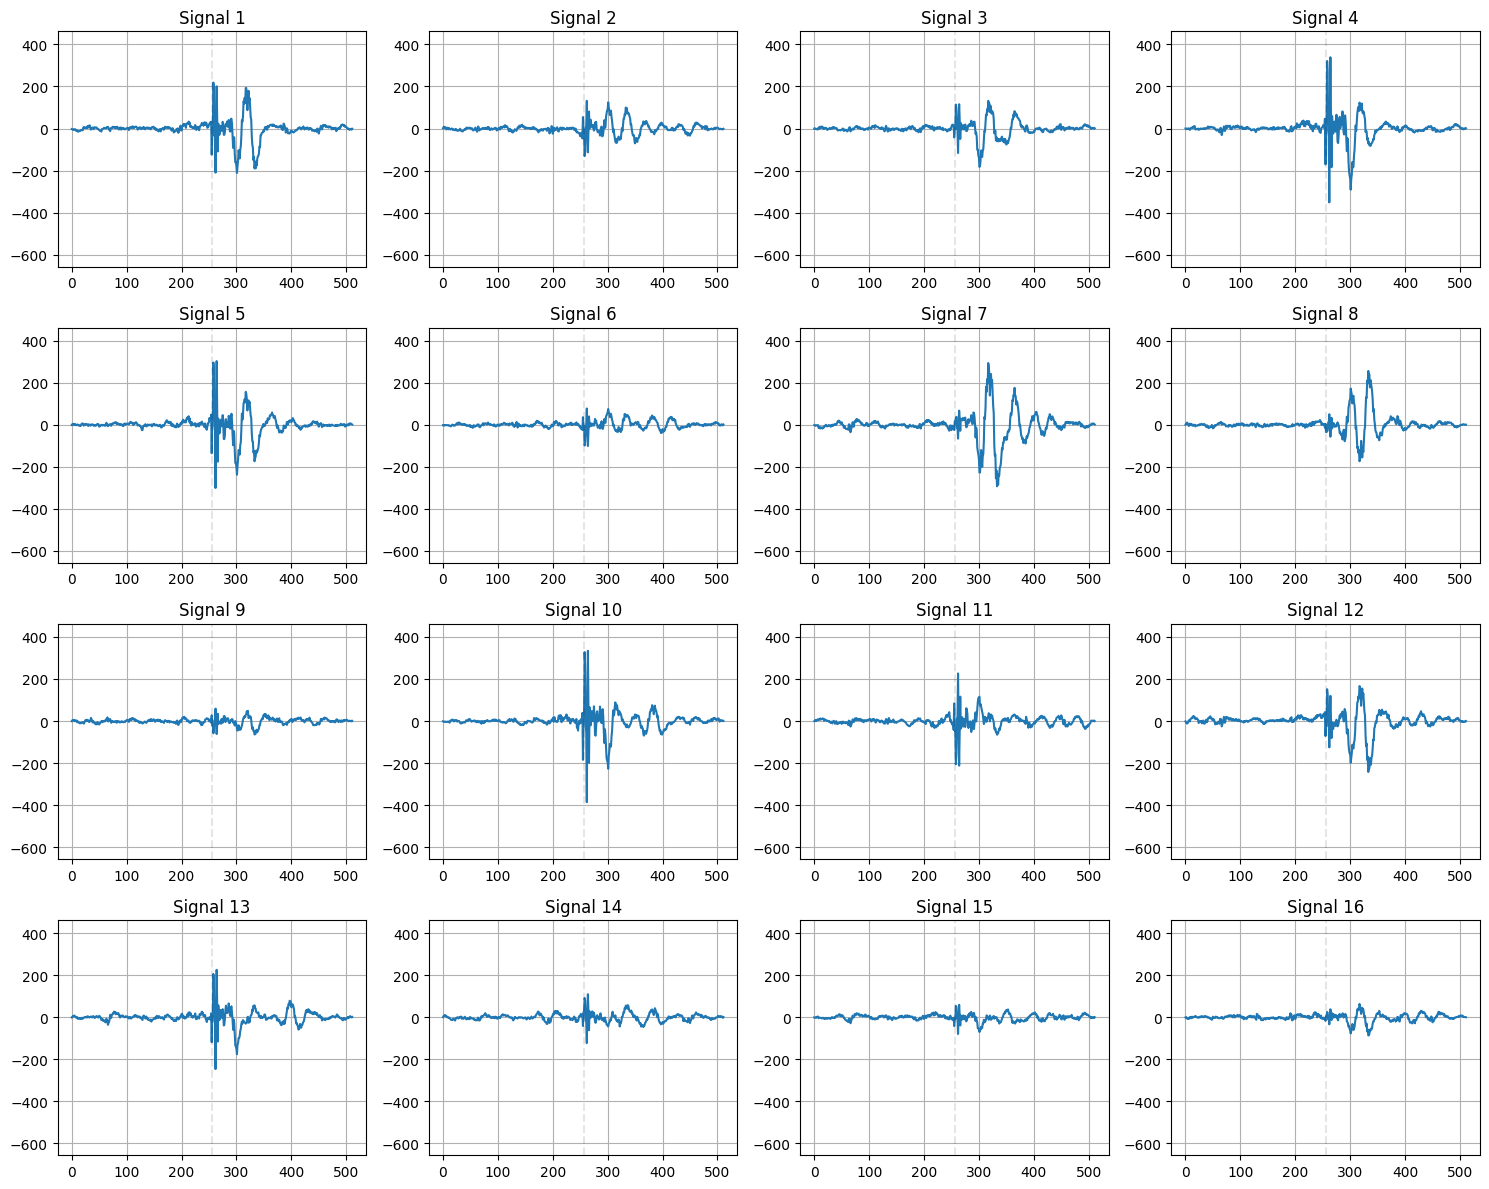

[14/20][0/187]	Loss_D: 1.1008	Loss_G: 3.6170	D(x): 0.1658	D(G(z)): 0.5450 / 0.8902
[14/20][50/187]	Loss_D: 0.6980	Loss_G: 3.4486	D(x): 0.1125	D(G(z)): 0.7787 / 0.8686
[14/20][100/187]	Loss_D: 0.9568	Loss_G: 2.2266	D(x): 0.1158	D(G(z)): 0.6943 / 0.7633
[14/20][150/187]	Loss_D: 0.8768	Loss_G: 3.1012	D(x): 0.1798	D(G(z)): 0.7632 / 0.8591


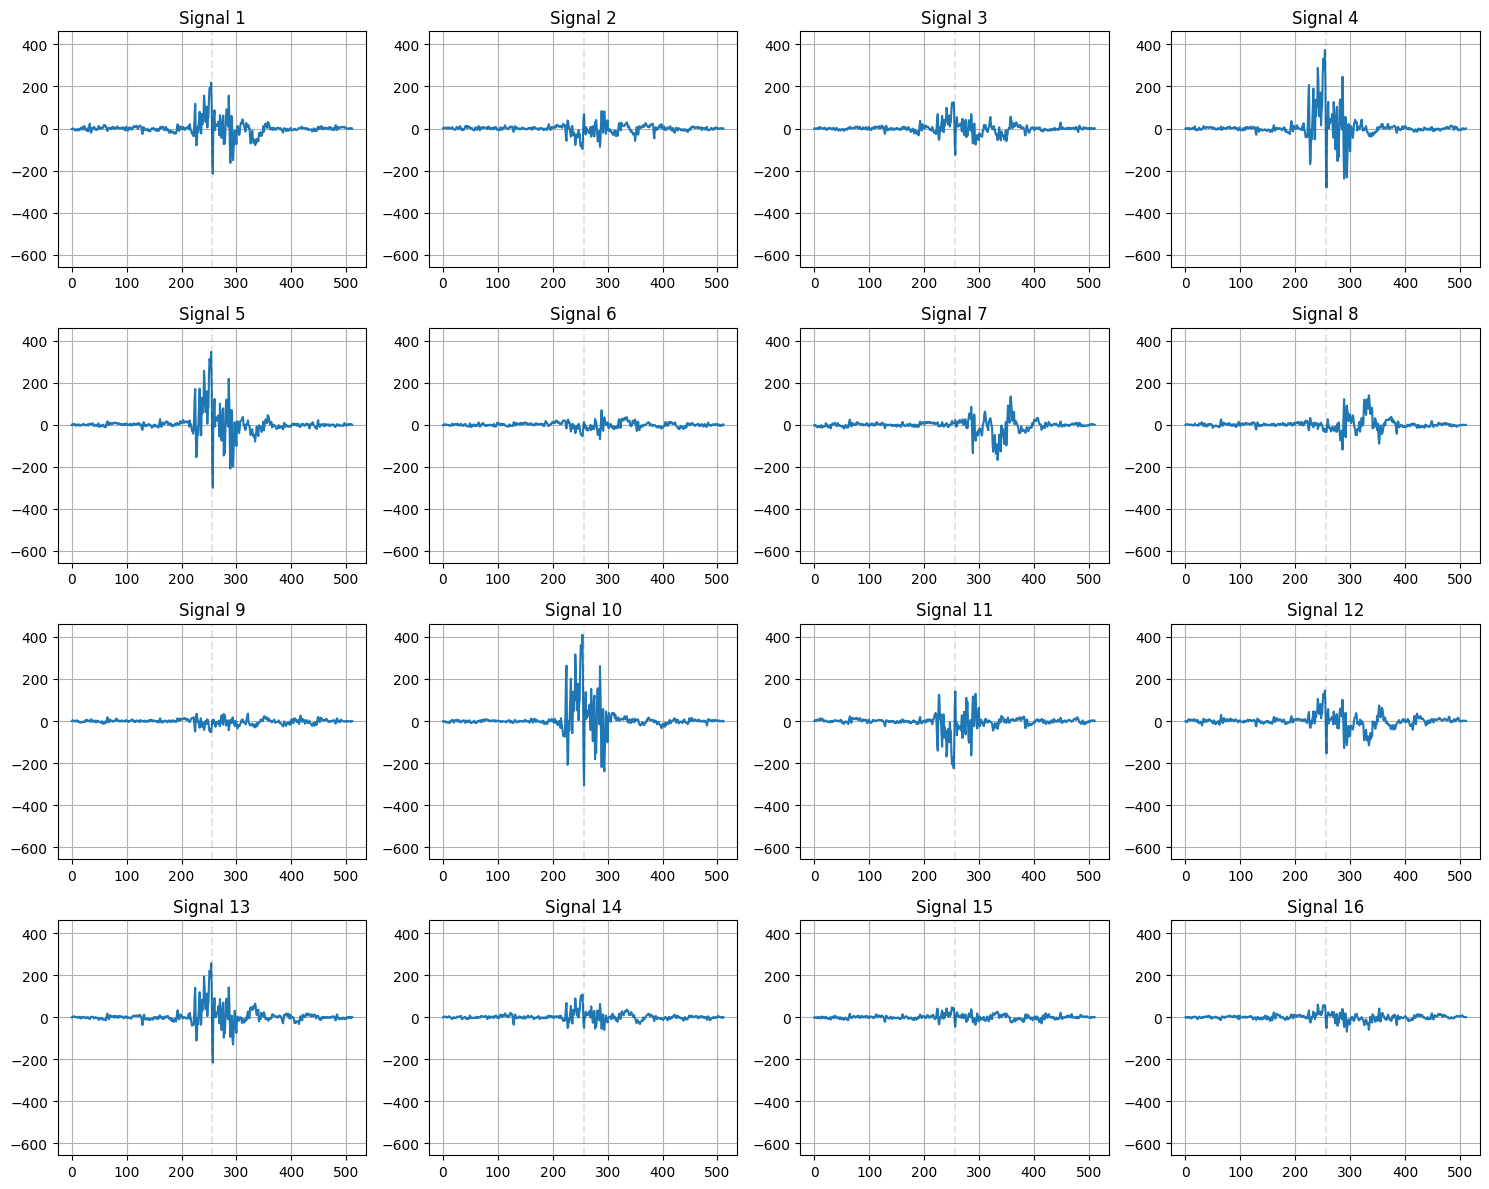

[15/20][0/187]	Loss_D: 0.6330	Loss_G: 2.2200	D(x): 0.0857	D(G(z)): 0.7332 / 0.7572
[15/20][50/187]	Loss_D: 0.5351	Loss_G: 2.8336	D(x): 0.0949	D(G(z)): 0.7979 / 0.7821
[15/20][100/187]	Loss_D: 0.8252	Loss_G: 2.9882	D(x): 0.1346	D(G(z)): 0.7409 / 0.7662
[15/20][150/187]	Loss_D: 0.5984	Loss_G: 1.9625	D(x): 0.1494	D(G(z)): 0.6837 / 0.6778


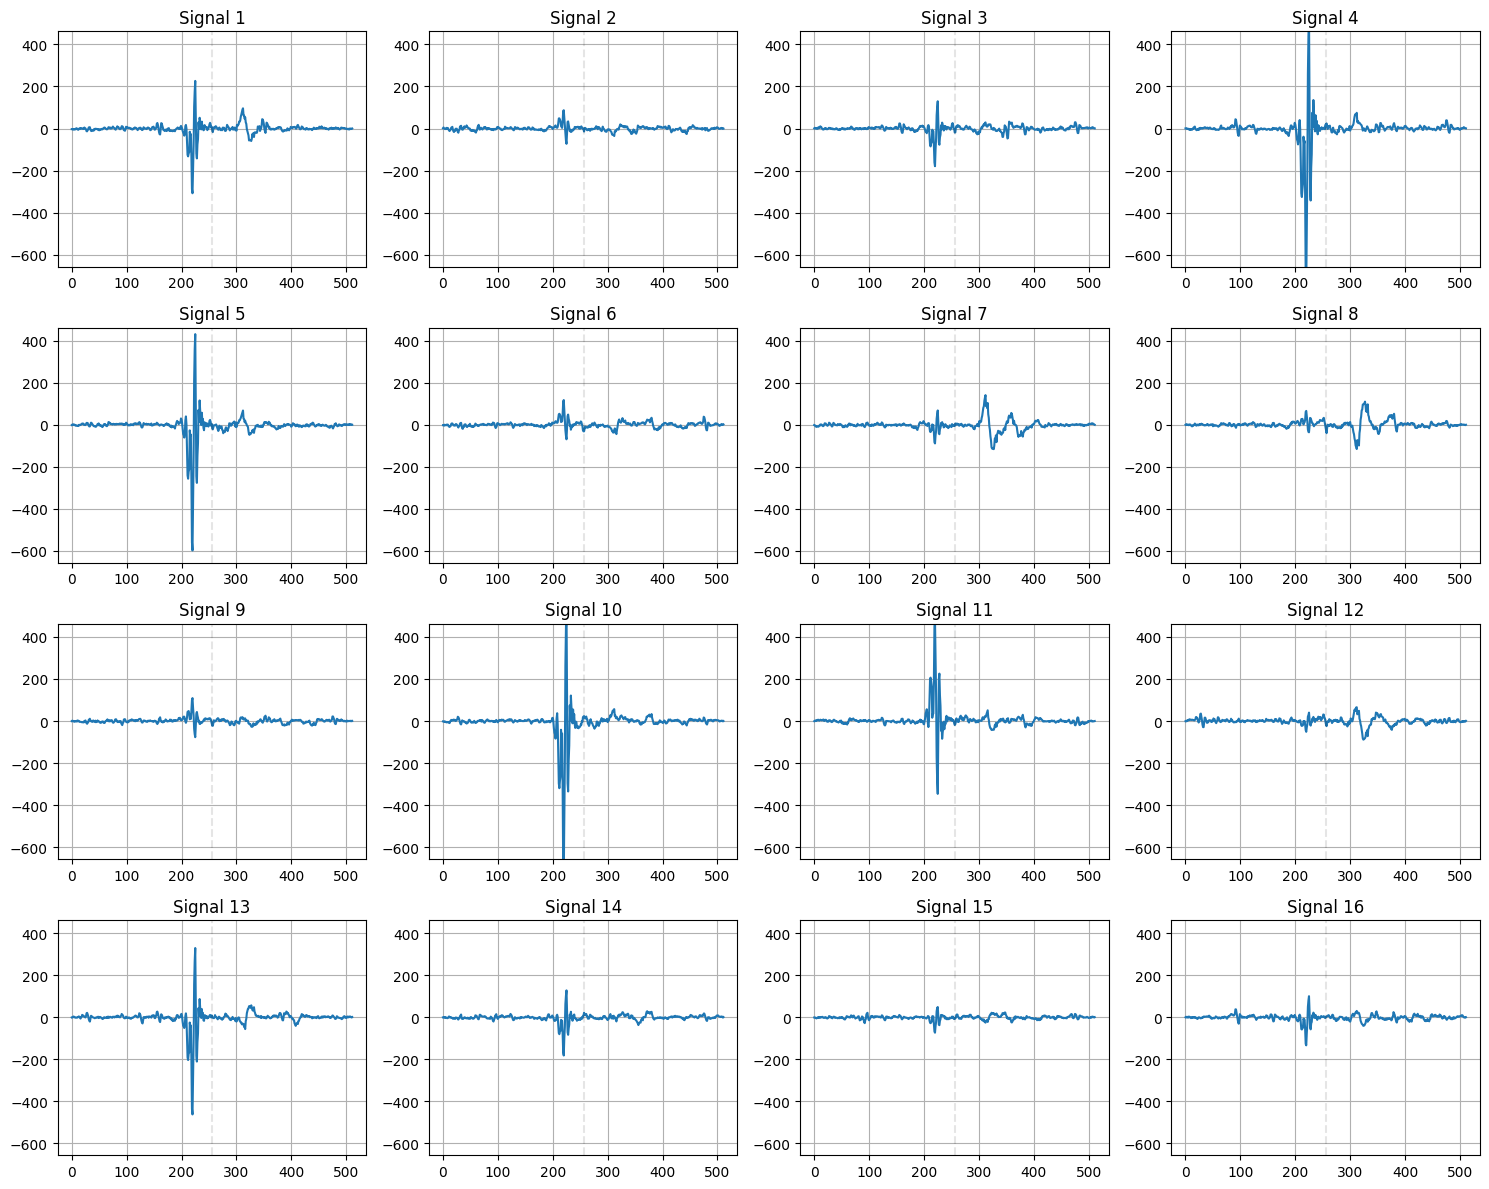

[16/20][0/187]	Loss_D: 1.0916	Loss_G: 2.8746	D(x): 0.1004	D(G(z)): 0.8337 / 0.7312
[16/20][50/187]	Loss_D: 0.6731	Loss_G: 2.8280	D(x): 0.1314	D(G(z)): 0.8274 / 0.8055
[16/20][100/187]	Loss_D: 1.0554	Loss_G: 2.6810	D(x): 0.2503	D(G(z)): 0.6776 / 0.8157
[16/20][150/187]	Loss_D: 0.8330	Loss_G: 2.6563	D(x): 0.1270	D(G(z)): 0.8378 / 0.8185


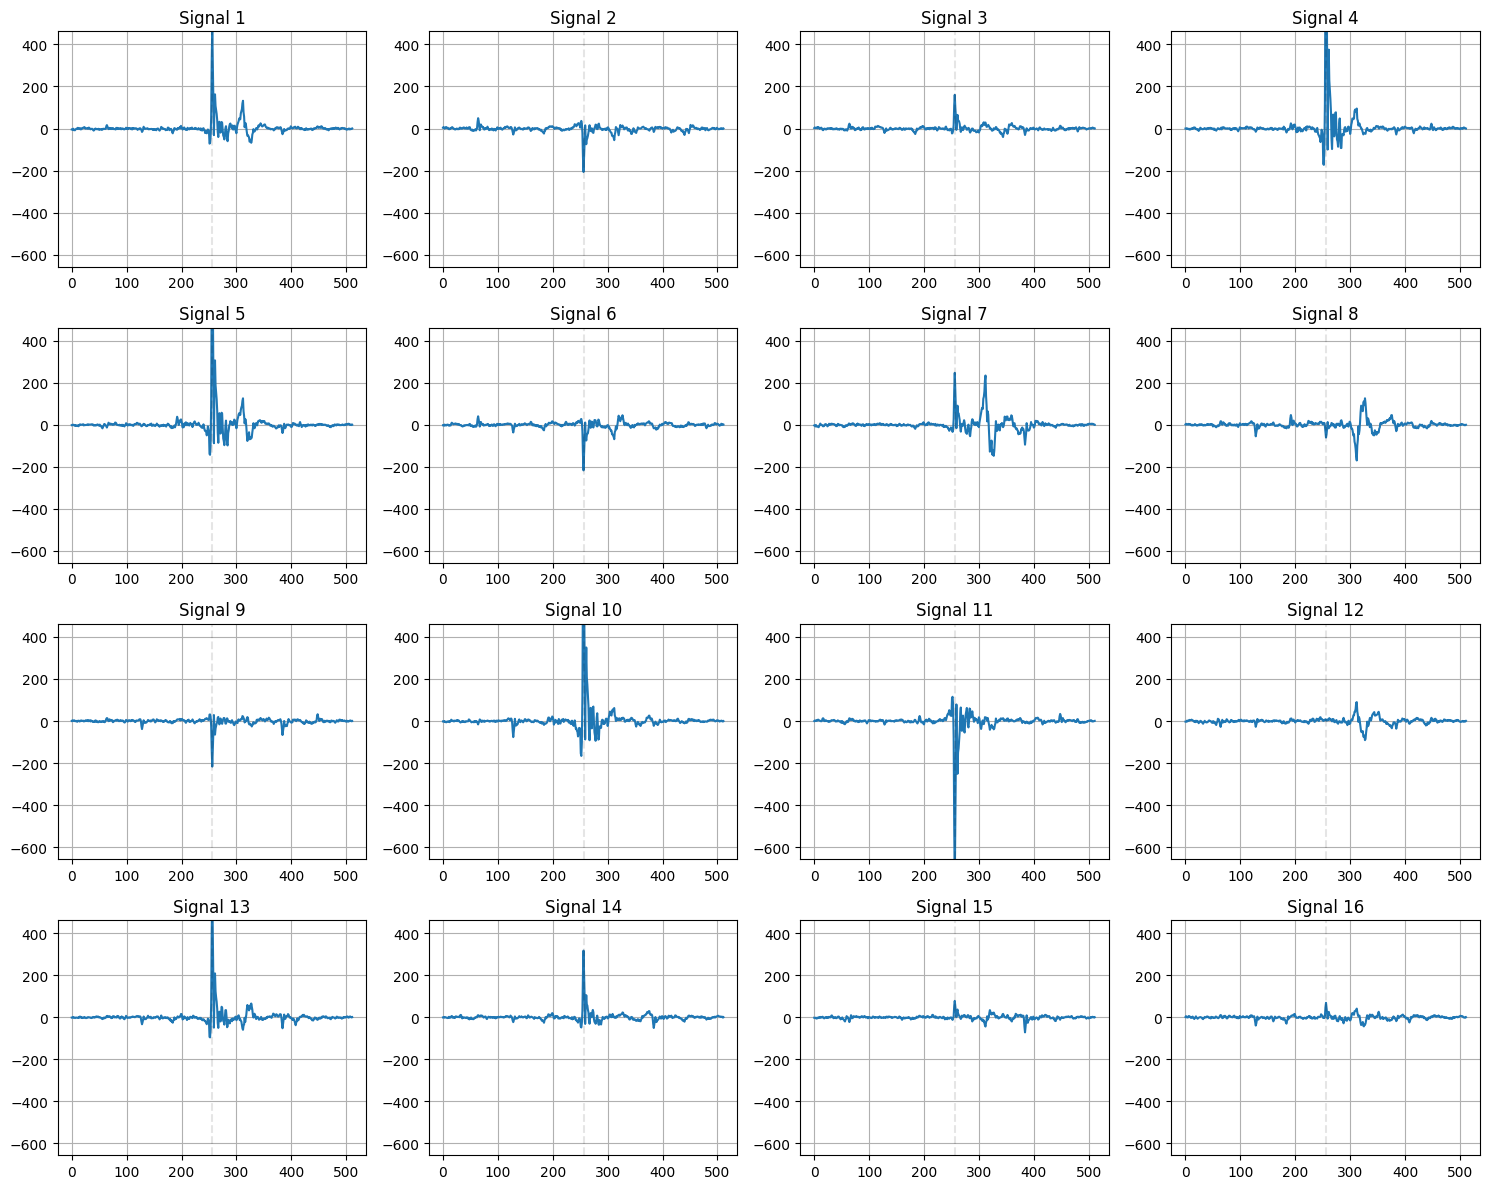

[17/20][0/187]	Loss_D: 1.0052	Loss_G: 1.6240	D(x): 0.1264	D(G(z)): 0.6558 / 0.6884
[17/20][50/187]	Loss_D: 0.7221	Loss_G: 2.5901	D(x): 0.0846	D(G(z)): 0.7409 / 0.8122
[17/20][100/187]	Loss_D: 0.9286	Loss_G: 2.1658	D(x): 0.1373	D(G(z)): 0.7493 / 0.7617
[17/20][150/187]	Loss_D: 0.9346	Loss_G: 3.3658	D(x): 0.1825	D(G(z)): 0.7281 / 0.8684


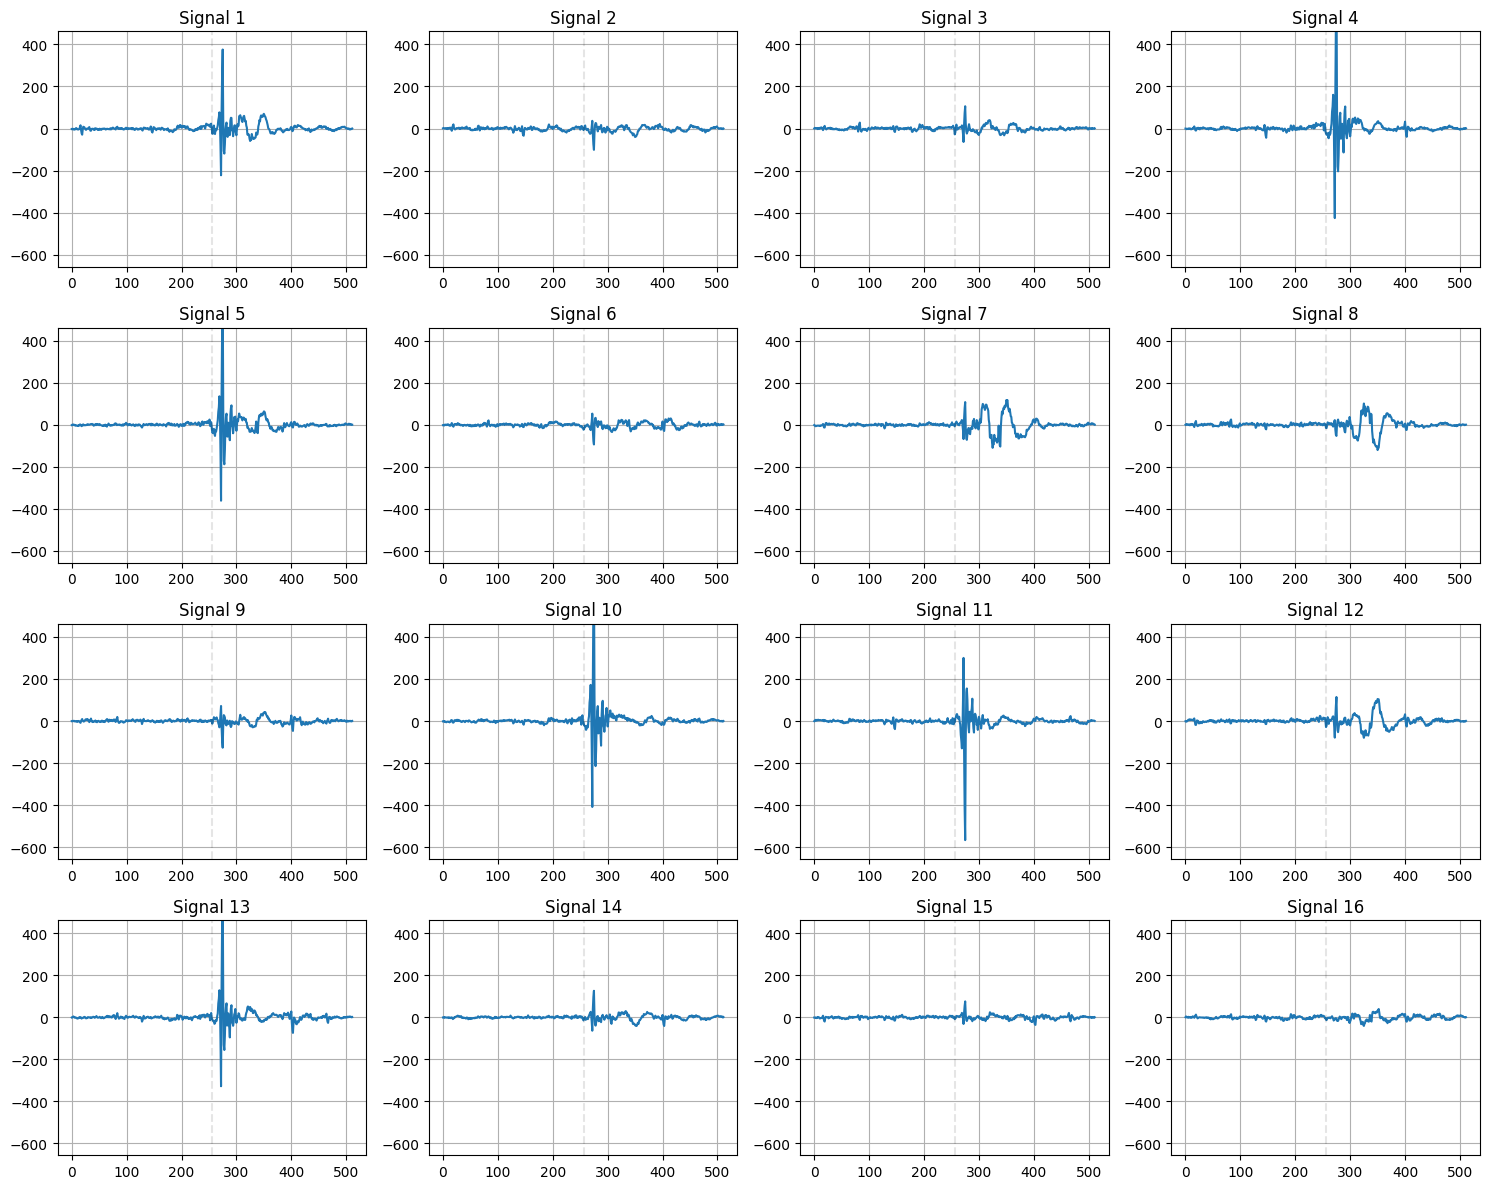

[18/20][0/187]	Loss_D: 0.7311	Loss_G: 1.6626	D(x): 0.1292	D(G(z)): 0.6955 / 0.6836
[18/20][50/187]	Loss_D: 0.4009	Loss_G: 2.0218	D(x): 0.1016	D(G(z)): 0.7817 / 0.7349
[18/20][100/187]	Loss_D: 0.9769	Loss_G: 2.9473	D(x): 0.1786	D(G(z)): 0.8439 / 0.8202
[18/20][150/187]	Loss_D: 0.7657	Loss_G: 2.3351	D(x): 0.1112	D(G(z)): 0.5684 / 0.8147


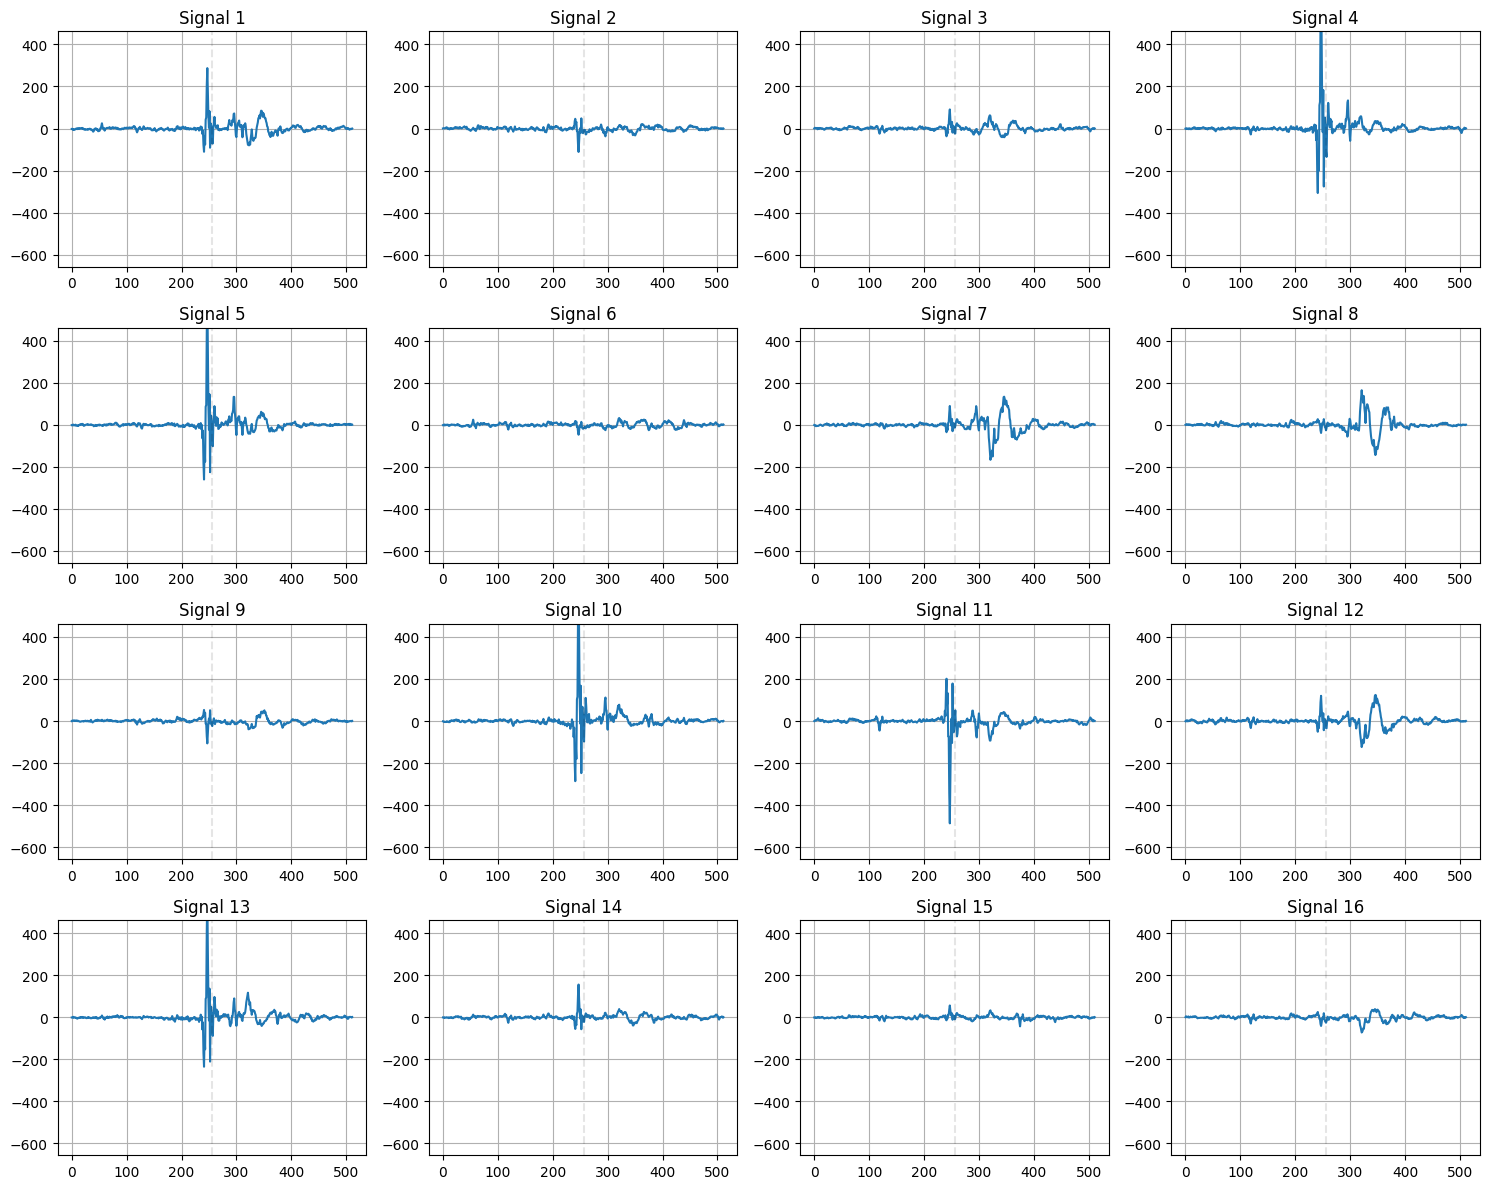

[19/20][0/187]	Loss_D: 0.5617	Loss_G: 2.5348	D(x): 0.0962	D(G(z)): 0.8596 / 0.7810
[19/20][50/187]	Loss_D: 1.1088	Loss_G: 3.2571	D(x): 0.1799	D(G(z)): 0.6550 / 0.7990
[19/20][100/187]	Loss_D: 0.7615	Loss_G: 3.1514	D(x): 0.1464	D(G(z)): 0.7736 / 0.8408
[19/20][150/187]	Loss_D: 0.9194	Loss_G: 2.2607	D(x): 0.1914	D(G(z)): 0.8163 / 0.7547


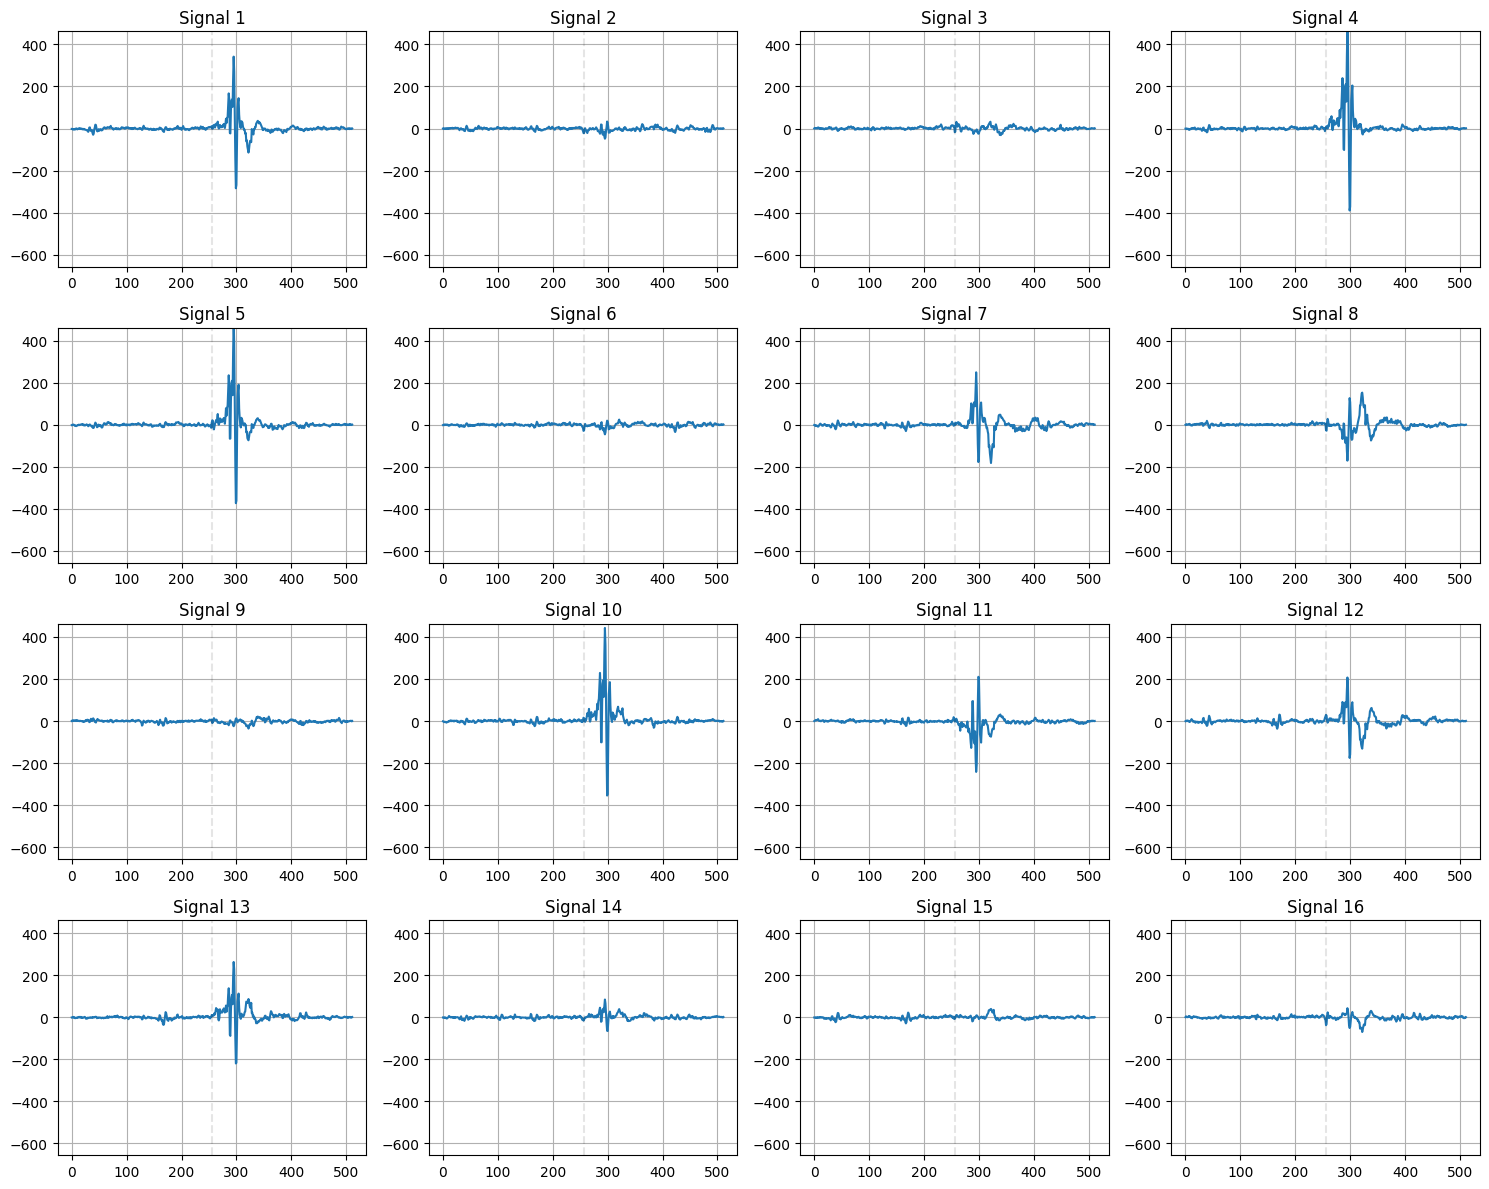

In [26]:
# Training Loop

# Lists to keep track of progress
signal_list = []
G_losses = []
D_losses = []
D_gradients = []
G_gradients = []
iters = 0

# label flip probability
flip_p = 1.0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_gpu = data.to(device)
        # print(real_gpu.shape)
        b_size = real_gpu.size(0)

        # determine which index of batch to flip on
        flip_mask = torch.rand(b_size) < flip_p

        # label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        label = torch.FloatTensor(b_size).uniform_(0.75, 1.25)
        label = torch.where(flip_mask, 1.0 - label, label).to(device)

        # Forward pass real batch through D
        output = netD(real_gpu).view(-1)
        # print(output)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, device=device)
        # Generate fake signal batch with G
        fake = netG(noise)
        # label.fill_(fake_label)
        label = torch.FloatTensor(b_size).uniform_(0.0, 0.25)
        label = torch.where(flip_mask, 1.0 - label, label).to(device)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()
        # Calculate gradients of discriminator parameters
        D_gradients.append([param.grad.norm().item() for param in netD.parameters()])

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        # label.fill_(real_label)  # fake labels are real for generator cost
        label = torch.FloatTensor(b_size).uniform_(0.75, 1.25)
        label = torch.where(flip_mask, 1.0 - label, label).to(device)
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()
        # Calculate gradients of generator parameters
        G_gradients.append([param.grad.norm().item() for param in netG.parameters()])

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        iters += 1 
    
    with torch.no_grad():
        fake_signals = netG(fixed_noise).detach().cpu()
        fig, axes = plt.subplots(4, 4, figsize=(15, 12))

        axes = axes.flatten()

        # plot each signal on a separate subplot
        for i, ax in enumerate(axes):
            x = np.arange(fake_signals.size(dim=2))
            y = fake_signals[i, :, :].flatten()
            y = y * gw_scaling_factor
            y = y * gw_std + gw_mean
            ax.plot(x, y)

            ax.axvline(x=256, color='black', linestyle='--', alpha=0.1)
            ax.set_title(f'Signal {i+1}')
            ax.grid(True)
            ax.set_ylim(common_ylim_signal)

        for i in range(512, 8*4):
            fig.delaxes(axes[i])

        plt.tight_layout()
        plt.savefig('../data/gw-dcgans-images/gw-dcgans_epoch_%d.png' % epoch)
        plt.show()

    signal_list.append(fake_signals)

### Gradients

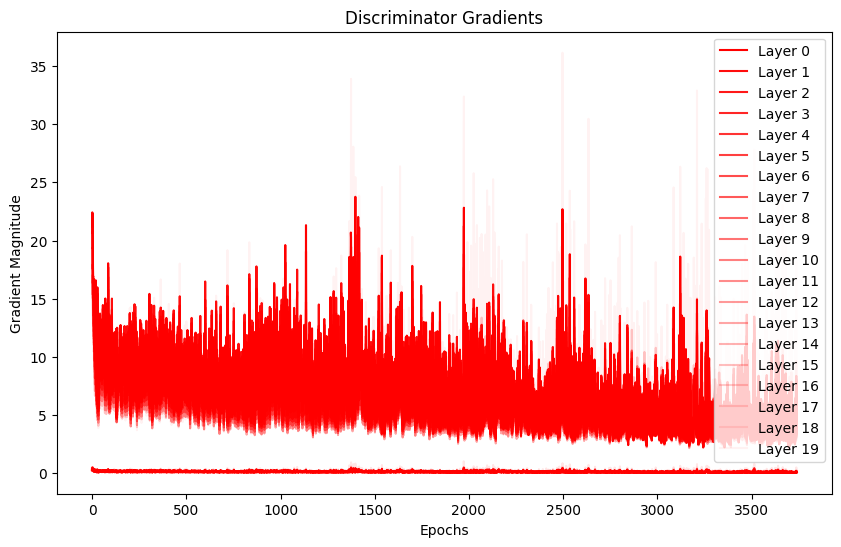

In [27]:
# Get the total number of layers in the discriminator
D_gradients = np.array(D_gradients)
num_layers = D_gradients.shape[1]

# Plot the gradients over training epochs
plt.figure(figsize=(10, 6))
for i in range(num_layers):
    # Calculate alpha value based on layer index
    alpha = 1 - (i / num_layers)  # Higher layers are more transparent
    plt.plot(D_gradients[:, i], label=f'Layer {i}', alpha=alpha, color=(1, 0, 0, alpha))

plt.xlabel('Epochs')
plt.ylabel('Gradient Magnitude')
plt.title('Discriminator Gradients')
plt.legend()
plt.show()

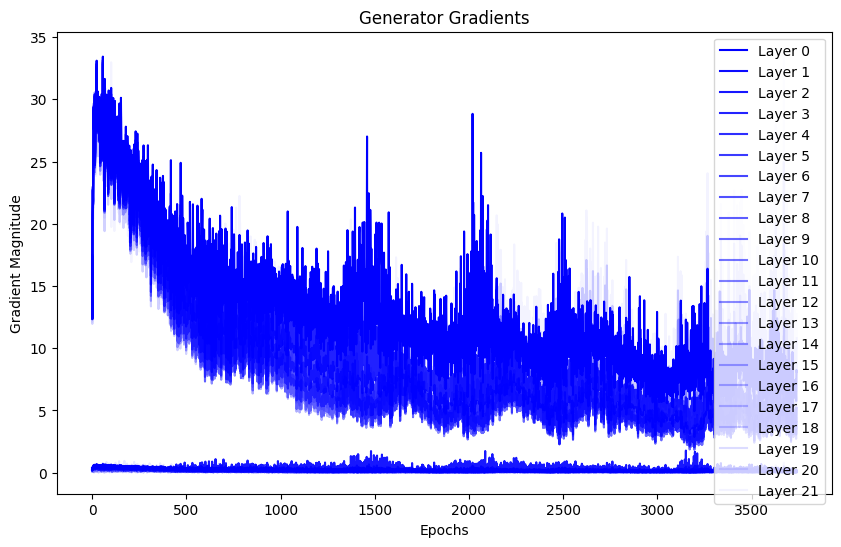

In [28]:
# Get the total number of layers in the discriminator
G_gradients = np.array(G_gradients)
num_layers = G_gradients.shape[1]

# Plot the gradients over training epochs
plt.figure(figsize=(10, 6))
for i in range(num_layers):
    # Calculate alpha value based on layer index
    alpha = 1 - (i / num_layers)  # Higher layers are more transparent
    plt.plot(G_gradients[:, i], label=f'Layer {i}', alpha=alpha, color=(0, 0, 1, alpha))

plt.xlabel('Epochs')
plt.ylabel('Gradient Magnitude')
plt.title('Generator Gradients')
plt.legend()
plt.show()

### Loss

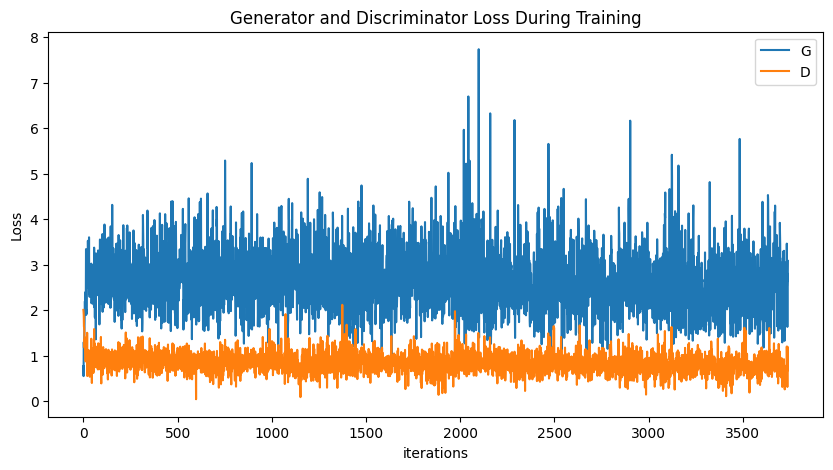

In [29]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

### Generated Signals

torch.Size([32, 1, 512])


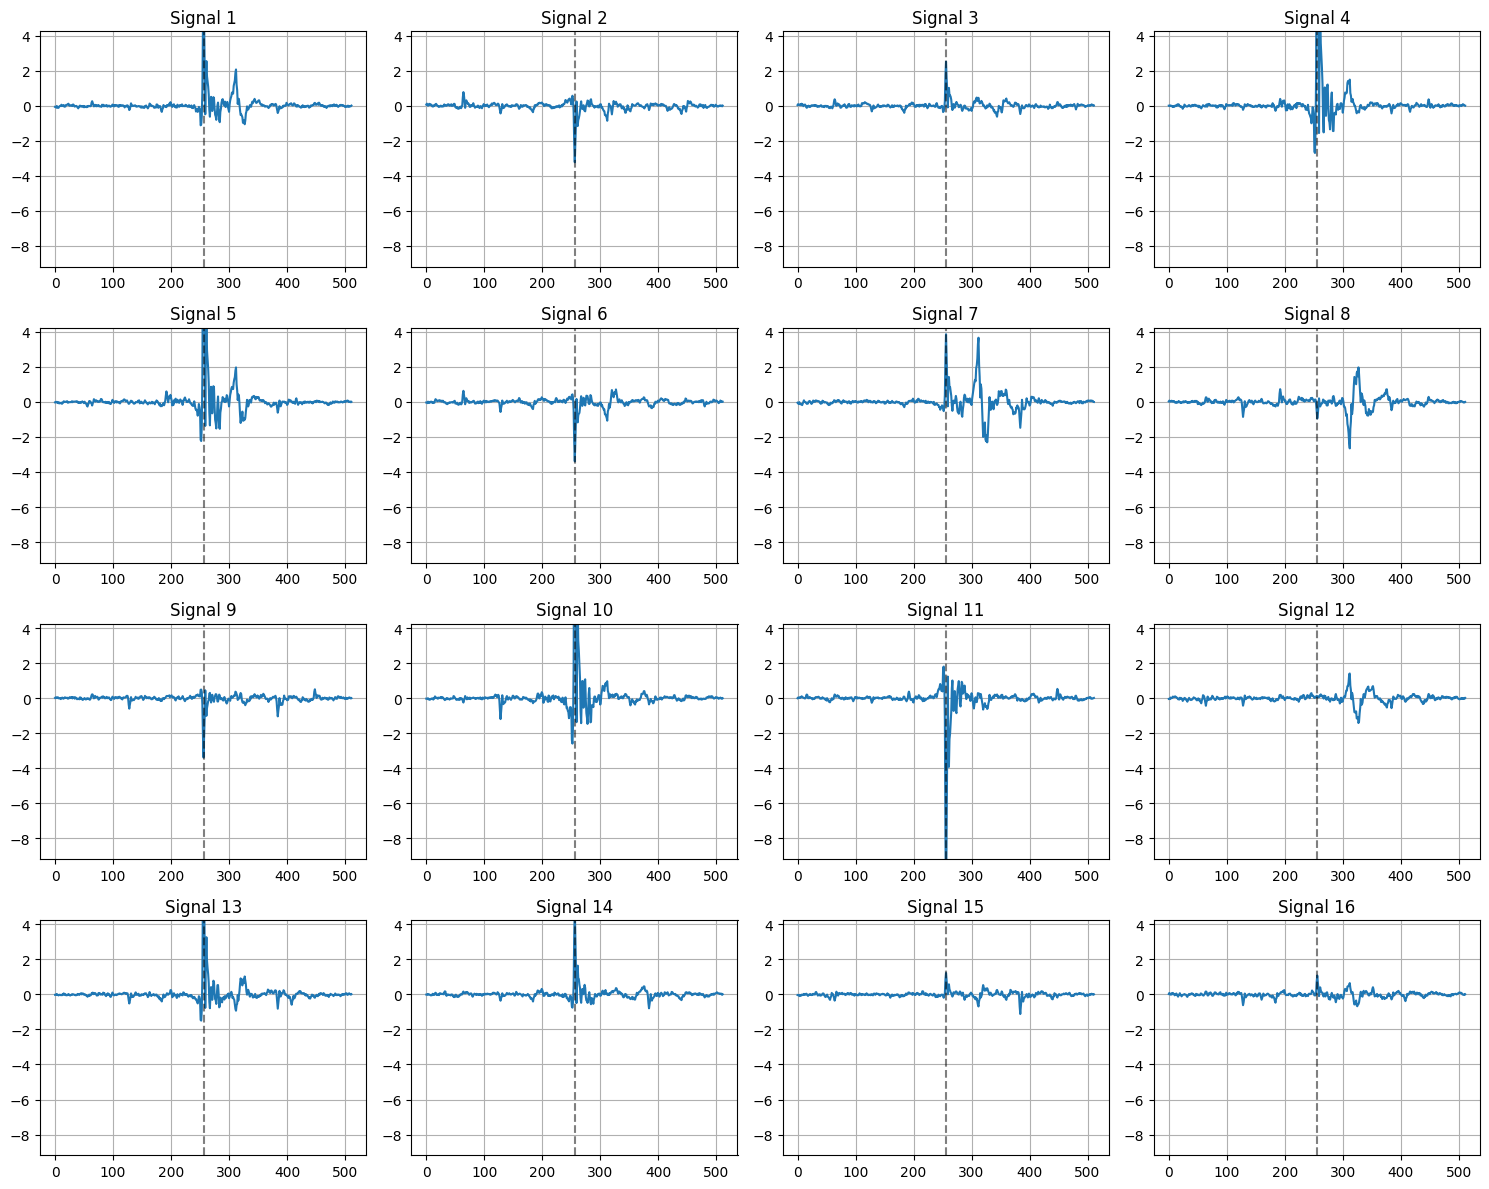

In [30]:
batch = signal_list[16]

# # plotting a single batch
# def plot_waveforms(batch):
#     fig, axs = plt.subplots(8, int(batch_size/8), figsize=(12, 12))
#     axs = axs.ravel()
    
#     for i in range(len(batch)):
#         signal = batch[i].squeeze()
#         axs[i].plot(signal)
#         axs[i].set_title(f'Signal {i+1}')
#         axs[i].axis('off')
    
#     plt.tight_layout()
#     plt.show()

# plot_waveforms(batch)

# Expecting: (32, 1, 512)
print(batch.shape)

# common_ylim = (batch[:,:,:].min(), batch[:,:,:].max())

fig, axes = plt.subplots(4, 4, figsize=(15, 12))

axes = axes.flatten()

# plot each signal on a separate subplot
for i, ax in enumerate(axes):
    x = np.arange(batch.size(dim=2))
    y = batch[i, :, :].flatten()
    ax.plot(x, y)

    ax.axvline(x=256, color='black', linestyle='--', alpha=0.5)
    ax.set_title(f'Signal {i+1}')
    ax.grid(True)
    ax.set_ylim(common_ylim)

for i in range(512, 8*4):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.savefig('../data/gw-dcgans-plots/generated_data.png')
plt.show()

In [31]:
# # Path to the folder containing PNG images
# image_folder = '../data/gw-dcgans-images'

# # Get a list of image filenames in the folder
# image_filenames = sorted([filename for filename in os.listdir(image_folder) if filename.endswith('.png')])

# # Load images and create an animation
# def update(frame):
#     img_path = os.path.join(image_folder, image_filenames[frame])
#     img = Image.open(img_path)
    
#     # Clear the previous plot
#     plt.clf()
    
#     # Display the image without cropping and centered
#     plt.imshow(img, aspect='auto')
#     plt.axis('off')

# fig = plt.figure(figsize=(8, 8))

# # Create the animation
# ani = animation.FuncAnimation(fig, update, frames=len(image_filenames), interval=1000, repeat_delay=1000)

# # Display the animation as HTML (for Jupyter Notebook) or save it to a file
# from IPython.display import HTML
# HTML(ani.to_jshtml())

# Save the animation as an .mp4 video
# output_filename = '../data/gw-dcgans-mp4/signals.mp4'
# ani.save(output_filename, writer='ffmpeg', codec='libx264', fps=8, dpi=100, bitrate=1800)

# print(f'Animation saved as {output_filename}')

In [32]:
# for signal processing
%store signal_list

Stored 'signal_list' (list)
